In [39]:
import sys
import json
params = {}
default = {'training_folder': '../../scenarios/houston/', 'params': params} # Default execution parameters
manual, argv = (True, default) if 'ipykernel' in sys.argv[0] else (False, dict(default, **json.loads(sys.argv[1])))
print(argv)


{'training_folder': '../../scenarios/houston/', 'params': {}}


In [40]:
import os
import time
import geopandas as gpd
import pandas as pd
sys.path.insert(0, r'../../../quetzal') # Add path to quetzal
from sklearn.neighbors import NearestNeighbors
from numba import jit, njit
import numba as nb
from quetzal.model import stepmodel
from shapely.geometry import LineString
from quetzal.io.gtfs_reader.importer import get_epsg
from quetzal.io import excel
on_lambda = bool(os.environ.get('AWS_EXECUTION_ENV'))
num_cores = nb.config.NUMBA_NUM_THREADS
print('num cores:',num_cores)

io_engine= 'pyogrio' if on_lambda else 'pyogrio' #or fiona

num cores: 8


In [41]:
import sys
sys.path.insert(0, r'../../../quetzal')
from quetzal.model import stepmodel
from quetzal.io import excel
import pandas as pd
if manual:
    %matplotlib inline

In [42]:
base_folder = argv['training_folder']
input_folder = os.path.join(base_folder,'inputs/')
pt_folder  = os.path.join(input_folder,'pt/')
road_folder = os.path.join(input_folder,'road/')
od_folder =  os.path.join(input_folder,'od/')
params_folder = input_folder if on_lambda else '../../inputs/'

output_folder = os.path.join(base_folder,'outputs/')
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    
model_folder = os.path.join(input_folder, 'model/')

In [43]:
sm = stepmodel.read_zippedpickles(model_folder +'los')
sm.segments = ['car_owner', 'pt_captive'] 

zones: 100%|██████████| 28/28 [00:03<00:00,  7.43it/s]          


In [44]:
var = excel.read_var(file=os.path.join(params_folder,'parameters.xlsx'), scenario='base', return_ancestry=False)
kwargs = var['preparation_logit'].to_dict()

utility_scale = var['preparation_logit']['time']
kwargs['transfers'] = -kwargs['transfers']/utility_scale # From min/transfer to pt/transfer
kwargs['price'] = -60/kwargs['price']/utility_scale # From 
kwargs['time'] = -1/utility_scale/60 # From min/pt to pt/sec
kwargs


{'time': -0.0008333333333333334,
 'price': -0.2,
 'mode': 1,
 'pt_mode': 0.5,
 'pt_path': 0.1,
 'transfers': -0.25}

In [45]:
sm.preparation_logit(
    segments=['car_owner', 'pt_captive'],
    **kwargs
)

In [46]:
sm.utility_values.T

value,time,price,ntransfers,mode_utility
segment,,,,
root,-0.000833,-0.2,-0.25,1.0
car_owner,-0.000833,-0.2,-0.25,1.0
pt_captive,-0.000833,-0.2,-0.25,1.0


In [47]:
sm.logit_scales.T 

route_type,bus,root,tram,walk,car,pt
segment,,,,,,
root,0.1,1.0,0.1,0.0,0.0,0.5
car_owner,0.1,1.0,0.1,0.0,0.0,0.5
pt_captive,0.1,1.0,0.1,0.0,0.0,0.5


In [48]:
sm.mode_utility.T

route_type,bus,root,tram,walk,car
segment,,,,,
root,0,0,0,0,0
car_owner,0,0,0,0,0
pt_captive,0,0,0,0,0


In [49]:
sm.mode_utility.loc[ 'car', 'pt_captive'] = -100
sm.mode_utility.T

route_type,bus,root,tram,walk,car
segment,,,,,
root,0,0,0,0,0
car_owner,0,0,0,0,0
pt_captive,0,0,0,0,-100


In [50]:
sm.mode_nests.T 

route_type,bus,root,tram,walk,car,pt
segment,,,,,,
root,pt,NaN,pt,root,root,root
car_owner,pt,NaN,pt,root,root,root
pt_captive,pt,NaN,pt,root,root,root


In [51]:
sm.pt_los['ntransfers'] = sm.pt_los['alighting_links'].apply(lambda x: max(len(x)-1, 0))
sm.pt_los['price'] = 0  ######
sm.car_los['ntransfers'] = 0
sm.car_los['price'] = 0

In [52]:
sm.analysis_pt_time(
        boarding_time=None,
        alighting_time=None,
        walk_on_road=True,
    )
 

sm.analysis_car_route_type() 

sm.los = pd.concat([sm.pt_los, sm.car_los]).reset_index(drop=True)
sm.los['path'] = sm.los['path'].apply(lambda p: tuple(p)) 


sm.analysis_mode_utility()

100%|██████████| 2/2 [00:00<00:00, 42.37it/s]


In [53]:
sm.initialize_logit()
sm.step_logit()

100%|██████████| 10/10 [00:00<00:00, 10.87it/s]


In [54]:
sm.volumes.fillna(0, inplace=True)
sm.compute_los_volume(keep_segments=False)

In [55]:
sm.los['volume'].sum()

3574545.4992814944

In [56]:
sm.pt_los = sm.los.copy()
sm.pt_los = sm.pt_los.loc[sm.pt_los['route_type'] != 'car']

In [57]:
sm.step_pt_assignment(
    road=True,
    boardings=True,
    alightings=True,
    transfers=True
 
)

pt_captive: 100%|██████████| 2/2 [00:04<00:00,  2.30s/it]


In [58]:
sm.links.rename(columns={'load': 'volume'}, inplace=True)
sm.analysis_pt_length(
     walk_on_road=True
)
sm.analysis_car_length()
sm.analysis_pt_time(
     walk_on_road=True
)

In [59]:
sm.summary_link_max(inplace=True)
sm.summary_link_sum(inplace=True)
sm.summary_od(inplace=True)

In [60]:
sm.los = pd.concat([sm.pt_los, sm.car_los]).reset_index(drop=True)

In [61]:
sm.summary_path_average(inplace=True)
sm.summary_aggregated_path_average(inplace=True, pt_route_types=['subway', 'bus', 'tram', 'rail'])
sm.summary_path_sum(inplace=True)

s = sm.stack_link_sum.unstack([-1, -2]).groupby(level=0).sum().stack([0, 1])
s.name = 'sum'
sm.stack_aggregated_link_sum = s 
s = sm.stack_link_max.unstack().groupby(level=0).max().stack()
s.name = 'max'
sm.stack_aggregated_link_max = s

In [62]:
sm.od_los.loc['zone_106', 'zone_129']


segment     car_owner                                                        \
sum            volume price          time in_vehicle_time in_vehicle_length   
mode                                                                          
car      0.000000e+00   0.0  0.000000e+00    0.000000e+00      0.000000e+00   
tram     6.047316e-20   0.0  7.774276e-17    4.282039e-18      6.194908e-17   

segment               pt_captive                                      \
sum        ntransfers     volume price          time in_vehicle_time   
mode                                                                   
car      0.000000e+00   0.000000   0.0      0.000000             0.0   
tram     1.165815e-21  25.009342   0.0  66685.327528          3673.0   

segment                                    root                      \
sum     in_vehicle_length ntransfers     volume price          time   
mode                                                                  
car                   0.0        0.0   0.000000   0.0      0.000000   
tram              53138.0        1.0  25.009342   0.0  66685.327528   

segment                                               
sum     in_vehicle_time in_vehicle_length ntransfers  
mode                                                  
car                 0.0               0.0        0.0  
tram             3673.0           53138.0        1.0

In [63]:
sm.probabilities.groupby(['segment'])['pt'].describe()

,count,mean,std,min,25%,50%,75%,max
segment,,,,,,,,
car_owner,67780.0,0.004983,0.021535,0.0,1.829612e-12,4.691556e-07,0.000312,0.406207
pt_captive,67780.0,0.918899,0.272992,0.0,1.000000e+00,1.000000e+00,1.000000,1.000000


In [64]:
sm.probabilities.loc[sm.probabilities['segment'] == 'car_owner'].sort_values(by='pt', ascending=False).head()

route_type,origin,destination,segment,root,car,walk,pt,tram,bus
10196,zone_58,zone_242,car_owner,1,0.593793,0.0,0.406207,0.0,0.406207
9720,zone_416,zone_154,car_owner,1,0.617625,0.0,0.382375,0.0,0.382375
4592,zone_274,zone_196,car_owner,1,0.617954,0.0,0.382046,0.0,0.382046
1780,zone_196,zone_274,car_owner,1,0.628041,0.0,0.371959,0.0,0.371959
10532,zone_445,zone_109,car_owner,1,0.629095,0.0,0.370905,0.0,0.370905


In [65]:
sm.links['boardings'].sum()


1804819.6103978134

In [66]:
sm.car_los

,origin,destination,time,path,gtime,node_path,link_path,ntlegs,ntransfers,price,route_types,route_type,access_length,in_vehicle_length,length
0,zone_467,zone_300,2333.754167,"[zone_467, road_node_89284, road_node_30244, r...",2333.754167,"[road_node_89284, road_node_30244, road_node_8...","[road_link_2775, road_link_2822, road_link_710...","[(zone_467, road_node_89284), (road_node_70686...",0,0,"(car,)",car,516.040905,37915.488245,38431.529150
1,zone_290,zone_9,3460.901940,"[zone_290, road_node_723, road_node_12557, roa...",3460.901940,"[road_node_723, road_node_12557, road_node_888...","[road_link_21485_r, road_link_56074_r, road_li...","[(zone_290, road_node_723), (road_node_42545, ...",0,0,"(car,)",car,1223.336079,49940.539263,51163.875342
2,zone_188,zone_388,2352.035409,"[zone_188, road_node_15180, road_node_71864, r...",2352.035409,"[road_node_15180, road_node_71864, road_node_4...","[road_link_9776, road_link_1245, road_link_600...","[(zone_188, road_node_15180), (road_node_7061,...",0,0,"(car,)",car,947.770798,23168.056870,24115.827668
3,zone_110,zone_421,3716.300131,"[zone_110, road_node_27936, road_node_72163, r...",3716.300131,"[road_node_27936, road_node_72163, road_node_7...","[road_link_52880, road_link_61791, road_link_4...","[(zone_110, road_node_27936), (road_node_18982...",0,0,"(car,)",car,565.490312,77559.621060,78125.111372
4,zone_241,zone_388,3693.382632,"[zone_241, road_node_71494, road_node_31228, r...",3693.382632,"[road_node_71494, road_node_31228, road_node_3...","[road_link_26525, road_link_36663, road_link_3...","[(zone_241, road_node_71494), (road_node_7061,...",0,0,"(car,)",car,539.024437,77708.364905,78247.389342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67775,zone_250,zone_132,4533.837094,"[zone_250, road_node_49256, road_node_32687, r...",4533.837094,"[road_node_49256, road_node_32687, road_node_2...","[road_link_56111_r, road_link_62045, road_link...","[(zone_250, road_node_49256), (road_node_72857...",0,0,"(car,)",car,1381.203353,69509.208571,70890.411924
67776,zone_387,zone_384,4001.682279,"[zone_387, road_node_25599, road_node_66607, r...",4001.682279,"[road_node_25599, road_node_66607, road_node_1...","[road_link_48840, road_link_64316, road_link_6...","[(zone_387, road_node_25599), (road_node_1788,...",0,0,"(car,)",car,747.986602,76261.133137,77009.119739
67777,zone_38,zone_36,2230.520172,"[zone_38, road_node_83617, road_node_26788, ro...",2230.520172,"[road_node_83617, road_node_26788, road_node_5...","[road_link_28155_r, road_link_38420, road_link...","[(zone_38, road_node_83617), (road_node_60370,...",0,0,"(car,)",car,418.126470,42289.195725,42707.322196
67778,zone_193,zone_430,3969.902068,"[zone_193, road_node_55679, road_node_39267, r...",3969.902068,"[road_node_55679, road_node_39267, road_node_6...","[road_link_25844_r, road_link_25839_r, road_li...","[(zone_193, road_node_55679), (road_node_62885...",0,0,"(car,)",car,1561.022430,50931.763184,52492.785614


In [67]:
sm.utilities

route_type,origin,destination,segment,root,car,walk,pt,tram,bus
0,zone_108,zone_104,car_owner,-7.176925,-7.176925,-inf,-39.192647,-inf,-39.192647
1,zone_108,zone_104,pt_captive,-39.192647,-107.176925,-inf,-39.192647,-inf,-39.192647
2,zone_108,zone_126,car_owner,-7.110302,-7.110302,-inf,-39.676047,-inf,-39.676047
3,zone_108,zone_126,pt_captive,-39.676047,-107.110302,-inf,-39.676047,-inf,-39.676047
4,zone_108,zone_129,car_owner,-7.111195,-7.111195,-inf,-38.416573,-38.416573,-inf
...,...,...,...,...,...,...,...,...,...
13567,zone_67,zone_87,pt_captive,-6.872732,-101.969576,-inf,-6.872732,-inf,-6.872732
13568,zone_67,zone_90,car_owner,-3.321733,-3.321733,-inf,-19.449839,-19.449839,-inf
13569,zone_67,zone_90,pt_captive,-19.449839,-103.321733,-inf,-19.449839,-19.449839,-inf
13570,zone_67,zone_97,car_owner,-3.351463,-3.351463,-inf,-27.372558,-27.372558,-inf


In [68]:
sm.probabilities

route_type,origin,destination,segment,root,car,walk,pt,tram,bus
0,zone_108,zone_104,car_owner,1,1.000000e+00,0.0,1.246662e-14,0.000000e+00,1.246662e-14
1,zone_108,zone_104,pt_captive,1,2.984030e-30,0.0,1.000000e+00,0.000000e+00,1.000000e+00
2,zone_108,zone_126,car_owner,1,1.000000e+00,0.0,7.192444e-15,0.000000e+00,7.192444e-15
3,zone_108,zone_126,pt_captive,1,5.172200e-30,0.0,1.000000e+00,0.000000e+00,1.000000e+00
4,zone_108,zone_129,car_owner,1,1.000000e+00,0.0,2.536573e-14,2.536573e-14,0.000000e+00
...,...,...,...,...,...,...,...,...,...
13567,zone_67,zone_87,pt_captive,1,5.011471e-42,0.0,1.000000e+00,0.000000e+00,1.000000e+00
13568,zone_67,zone_90,car_owner,1,9.999999e-01,0.0,9.900396e-08,9.900396e-08,0.000000e+00
13569,zone_67,zone_90,pt_captive,1,3.757502e-37,0.0,1.000000e+00,1.000000e+00,0.000000e+00
13570,zone_67,zone_97,car_owner,1,1.000000e+00,0.0,3.696332e-11,3.696332e-11,0.000000e+00


In [69]:
sm.od_los

segment                  car_owner                                   \
sum                         volume price       time in_vehicle_time   
origin  destination mode                                              
zone_0  zone_1      bus   0.008931   0.0   4.285161        1.885705   
                    car   0.000000   0.0   0.000000        0.000000   
        zone_104    bus   0.684262   0.0  46.308404       32.382759   
                    car   0.000000   0.0   0.000000        0.000000   
        zone_109    bus   0.367206   0.0  56.616397       30.689838   
...                            ...   ...        ...             ...   
zone_99 zone_85     car   0.000000   0.0   0.000000        0.000000   
        zone_87     bus   0.000002   0.0   0.001500        0.000256   
                    car   0.000000   0.0   0.000000        0.000000   
        zone_90     car   0.000000   0.0   0.000000        0.000000   
                    walk  0.000001   0.0   0.000584        0.000000   

segment                                                  pt_captive        \
sum                      in_vehicle_length    ntransfers     volume price   
origin  destination mode                                                    
zone_0  zone_1      bus          29.907679  1.064368e-03   0.000000   0.0   
                    car           0.000000  0.000000e+00   0.000000   0.0   
        zone_104    bus         208.391380  1.359192e-02  50.702857   0.0   
                    car           0.000000  0.000000e+00   0.000000   0.0   
        zone_109    bus         434.771484  2.194744e-02   0.000000   0.0   
...                                    ...           ...        ...   ...   
zone_99 zone_85     car           0.000000  0.000000e+00   0.000000   0.0   
        zone_87     bus           0.003252  6.439803e-08  25.475000   0.0   
                    car           0.000000  0.000000e+00   0.000000   0.0   
        zone_90     car           0.000000  0.000000e+00   0.000000   0.0   
                    walk          0.000000  0.000000e+00   0.000000   0.0   

segment                                                                   \
sum                               time in_vehicle_time in_vehicle_length   
origin  destination mode                                                   
zone_0  zone_1      bus   12078.042640          5315.0           84297.0   
                    car       0.000000             0.0               0.0   
        zone_104    bus    6814.105732          4765.0           30664.0   
                    car       0.000000             0.0               0.0   
        zone_109    bus    7738.906510          4195.0           59429.0   
...                                ...             ...               ...   
zone_99 zone_85     car       0.000000             0.0               0.0   
        zone_87     bus   23299.386085          3970.0           50504.0   
                    car       0.000000             0.0               0.0   
        zone_90     car       0.000000             0.0               0.0   
                    walk  24321.227058             0.0               0.0   

segment                                   root                      \
sum                      ntransfers     volume price          time   
origin  destination mode                                             
zone_0  zone_1      bus         3.0   0.008931   0.0      4.285161   
                    car         0.0   0.000000   0.0      0.000000   
        zone_104    bus         2.0  51.387119   0.0   6723.986938   
                    car         0.0   0.000000   0.0      0.000000   
        zone_109    bus         3.0   0.367206   0.0     56.616397   
...                             ...        ...   ...           ...   
zone_99 zone_85     car         0.0   0.000000   0.0      0.000000   
        zone_87     bus         1.0  25.475002   0.0  23299.384609   
                    car         0.0   0.000000   0.0      0.000000   
        zone_90     c

In [70]:
sm.to_zippedpickles(model_folder + 'logit_assignment')

  0%|          | 0/47 [00:00<?, ?it/s]

stack_aggregated_link_max: 100%|██████████| 47/47 [00:21<00:00,  2.16it/s]


In [82]:
od_list= sm.volumes.loc[sm.volumes['pt_captive']==0.001][['origin','destination']].values.tolist()

In [83]:
sm.pt_los.set_index(['origin','destination']).loc[od_list]

,,gtime,path,pathfinder_session,reversed,route_id_set,route_type_set,boardings,alightings,node_path,link_path,...,pt_captive,volume,pivot,access_length,footpath_length,in_vehicle_length,length,route_path,min,title
origin,destination,,,,,,,,,,,,,,,,,,,,,
zone_446,zone_83,8003.531299,"(zone_446, 3455, link_1355, link_1356, link_13...",best_path,False,"{HOU_003, HOU_008}","{bus, tram}","[3455, 1786, 512]","[460, 512, 629]","[3455, 460, 1786, 512, 629]","[link_1355, link_1356, link_1357, link_1358, l...",...,0.001,0.001,1.0,501.978521,343.431511,34363.0,35208.410032,"[008, 700, 003]",133,P = 100% | 1 transfers | 133 mins | 008—>700—...
zone_239,zone_443,12516.741854,"(zone_239, road_node_28422, road_node_60745, r...",best_path,False,"{HOU_096, HOU_228}",{bus},"[2270, 1014, 1115]","[4162, 817, 673]","[road_node_28422, road_node_60745, road_node_3...","[link_12043, link_12044, link_12045, link_1204...",...,0.001,0.001,1.0,256.229925,8924.078173,44622.0,53802.308098,"[228, 108, 096]",209,P = 100% | 0 transfers | 209 mins | 228—>108—...
zone_386,zone_300,4903.993637,"(zone_386, road_node_30783, road_node_63616, r...",best_path,False,"{HOU_050, HOU_009}",{bus},"[64, 845]","[845, 377]","[road_node_30783, road_node_63616, road_node_9...","[link_1446, link_1447, link_1448, link_1449, l...",...,0.001,0.001,1.0,485.930039,747.826052,19473.0,20706.756091,"[009, 050]",82,P = 100% | 1 transfers | 82 mins | 009—>050\n...
zone_137,zone_144,5000.791272,"(zone_137, road_node_56631, road_node_81882, r...",best_path,False,"{HOU_020, HOU_137}",{bus},"[139, 2997]","[2997, 2853]","[road_node_56631, road_node_81882, road_node_5...","[link_2026, link_2027, link_2028, link_2029, l...",...,0.001,0.001,1.0,443.487289,1270.439679,17563.0,19276.926968,"[020, 137]",83,P = 100% | 1 transfers | 83 mins | 020—>137\n...
zone_203,zone_247,5358.580717,"(zone_203, 1170, link_7924, link_7925, link_79...",best_path,False,"{HOU_070, HOU_085}",{bus},"[1170, 804]","[129, 1439]","[1170, 129, 804, 1439]","[link_7924, link_7925, link_7926, link_7927, l...",...,0.001,0.001,1.0,1126.854963,97.681698,10169.0,11393.536660,"[070, 085]",89,P = 100% | 0 transfers | 89 mins | 070—>085\n...
zone_176,zone_298,8587.585470,"(zone_176, road_node_2114, road_node_62594, ro...",best_path,False,"{HOU_216, HOU_029}","{bus, tram}","[2364, 1379, 1392]","[1379, 1392, 1391]","[road_node_2114, road_node_62594, road_node_73...","[link_12013, link_12014, link_12015, link_1201...",...,0.001,0.001,1.0,1236.938982,2413.147223,35905.0,39555.086205,"[216, 800, 029]",143,P = 100% | 2 transfers | 143 mins | 216—>800—...
zone_488,zone_4,4447.897741,"(zone_488, 1357, link_4793, link_4794, link_47...",best_path,False,"{HOU_002, HOU_044}","{bus, tram}","[1357, 2882, 2009]","[1234, 1016, 1368]","[1357, 1234, 2882, 1016, 2009, 1368]","[link_4793, link_4794, link_4795, link_4796, l...",...,0.001,0.001,1.0,766.189707,254.320738,11462.0,12482.510445,"[044, 700, 002]",74,P = 100% | 0 transfers | 74 mins | 044—>700—>...
zone_174,zone_488,4846.048396,"(zone_174, 2016, link_11081, link_11082, link_...",best_path,False,"{HOU_102, HOU_044}",{bus},"[2016, 3987]","[2169, 1357]","[2016, 2169, road_node_66212, road_node_38818,...","[link_11081, link_11082, link_11083, link_1108...",...,0.001,0.001,1.0,328.185686,101.327571,42982.0,43411.513257,"[102, 044]",81,P = 100% | 0 transfers | 81 mins | 102—>044\n...
zone_382,zone_179,3781.322122,"(zone_382, 108, link_174, link_175, link_176, ...",best_path,False,"{HOU_002, HOU_046}",{bus},"[108, 1794]","[2298, 789]","[108, 2298, 1794, 789]","[link_174, link_175, link_176, link_177, link_...",...,0.001,0.001,1.0,189.920321,159.957781,15878.0,16227.878102,"[002, 046]",63,P = 100% | 0 transfers | 63 mins | 002—>046\n...


In [96]:
sm.probabilities.set_index(['segment', 'origin', 'destination']).loc['car_owner'].loc[od_list]

,route_type,root,car,walk,pt,tram,bus
origin,destination,,,,,,
zone_446,zone_83,1,0.996541,0.0,0.003459,0.003459,0.000000
zone_239,zone_443,1,0.999909,0.0,0.000091,0.000000,0.000091
zone_386,zone_300,1,0.962974,0.0,0.037026,0.000000,0.037026
zone_137,zone_144,1,0.964945,0.0,0.035055,0.000000,0.035055
zone_203,zone_247,1,0.982239,0.0,0.017761,0.000000,0.017761
zone_176,zone_298,1,0.994784,0.0,0.005216,0.005216,0.000000
zone_488,zone_4,1,0.963944,0.0,0.036056,0.036056,0.000000
zone_174,zone_488,1,0.934812,0.0,0.065188,0.000000,0.065188
zone_382,zone_179,1,0.934086,0.0,0.065914,0.000000,0.065914


In [99]:
sm.links['boardings'].sum()

1804819.6103978134

In [101]:
sm.links['volume'].max()

45115.47135845348

In [104]:
sm.volumes['pt_captive'].sum()

714964.2089999998

In [89]:
sm.od_los

segment                  car_owner                                   \
sum                         volume price       time in_vehicle_time   
origin  destination mode                                              
zone_0  zone_1      bus   0.008931   0.0   4.285161        1.885705   
                    car   0.000000   0.0   0.000000        0.000000   
        zone_104    bus   0.684262   0.0  46.308404       32.382759   
                    car   0.000000   0.0   0.000000        0.000000   
        zone_109    bus   0.367206   0.0  56.616397       30.689838   
...                            ...   ...        ...             ...   
zone_99 zone_85     car   0.000000   0.0   0.000000        0.000000   
        zone_87     bus   0.000002   0.0   0.001500        0.000256   
                    car   0.000000   0.0   0.000000        0.000000   
        zone_90     car   0.000000   0.0   0.000000        0.000000   
                    walk  0.000001   0.0   0.000584        0.000000   

segment                                                  pt_captive        \
sum                      in_vehicle_length    ntransfers     volume price   
origin  destination mode                                                    
zone_0  zone_1      bus          29.907679  1.064368e-03   0.000000   0.0   
                    car           0.000000  0.000000e+00   0.000000   0.0   
        zone_104    bus         208.391380  1.359192e-02  50.702857   0.0   
                    car           0.000000  0.000000e+00   0.000000   0.0   
        zone_109    bus         434.771484  2.194744e-02   0.000000   0.0   
...                                    ...           ...        ...   ...   
zone_99 zone_85     car           0.000000  0.000000e+00   0.000000   0.0   
        zone_87     bus           0.003252  6.439803e-08  25.475000   0.0   
                    car           0.000000  0.000000e+00   0.000000   0.0   
        zone_90     car           0.000000  0.000000e+00   0.000000   0.0   
                    walk          0.000000  0.000000e+00   0.000000   0.0   

segment                                                                   \
sum                               time in_vehicle_time in_vehicle_length   
origin  destination mode                                                   
zone_0  zone_1      bus   12078.042640          5315.0           84297.0   
                    car       0.000000             0.0               0.0   
        zone_104    bus    6814.105732          4765.0           30664.0   
                    car       0.000000             0.0               0.0   
        zone_109    bus    7738.906510          4195.0           59429.0   
...                                ...             ...               ...   
zone_99 zone_85     car       0.000000             0.0               0.0   
        zone_87     bus   23299.386085          3970.0           50504.0   
                    car       0.000000             0.0               0.0   
        zone_90     car       0.000000             0.0               0.0   
                    walk  24321.227058             0.0               0.0   

segment                                   root                      \
sum                      ntransfers     volume price          time   
origin  destination mode                                             
zone_0  zone_1      bus         3.0   0.008931   0.0      4.285161   
                    car         0.0   0.000000   0.0      0.000000   
        zone_104    bus         2.0  51.387119   0.0   6723.986938   
                    car         0.0   0.000000   0.0      0.000000   
        zone_109    bus         3.0   0.367206   0.0     56.616397   
...                             ...        ...   ...           ...   
zone_99 zone_85     car         0.0   0.000000   0.0      0.000000   
        zone_87     bus         1.0  25.475002   0.0  23299.384609   
                    car         0.0   0.000000   0.0      0.000000   
        zone_90     c

In [105]:
sm.volumes['car_owner'].sum()

2859581.290281494

In [90]:
sm.od_los['car_owner'].loc[od_list]

ValueError: operands could not be broadcast together with shapes (9,2) (3,) (9,2) 

In [71]:
help(sm.plot_separated_paths)

Help on method plot_separated_paths in module quetzal.model.plotmodel:

plot_separated_paths(origin, destination, ax=None, rows=1, title=None, titlesize=12, basemap_url=None, basemap_raster=None, north_arrow=None, scalebar=None, zoom=9, resize=False, *args, **kwargs) method of quetzal.model.stepmodel.StepModel instance



In [72]:

import numpy as np
paths = sm.pt_los
link_routes = sm.links['route_short_name'].to_dict()
def link_path_to_routes(link_path):
    routes = [link_routes[l] for l in link_path]
    used = set()
    rsn = []
    for route in routes:
        if route not in used:
            rsn.append(route)
        used.add(route)
    return rsn

paths['route_path'] = paths['link_path'].apply(link_path_to_routes)
paths['ntransfers'] = paths['transfers'].apply(len)

def title(paths):
    paths['min'] = np.round(paths['time'] / 60).astype(int)
    mins = (paths[['in_vehicle_time', 'access_time', 'footpath_time', 'waiting_time', 'time']] / 60).astype(int).astype(str)
    title = 'P = ' + (np.round(paths[('pt_captive', 'probability')], 2).fillna(0) * 100).astype(int).astype(str) + '%'
    title += ' | '+  paths['ntransfers'].astype(str) + ' transfers '
    title += ' | '+  paths['min'].astype(str) + ' mins | '
    title += paths['route_path'].apply(lambda l: '—>'.join(l) )
    title += '\n'+ 'in vehicle '+ mins['in_vehicle_time']+ "' | " + ' waiting '+ mins['waiting_time']+ "' | "  
    title += 'access ' + mins['access_time']+ "' | "   + ' footpaths '  + mins['footpath_time']+ "'"   
    return title


paths['title'] = title(paths)

In [73]:
plot_sm = sm.copy()

In [74]:
los = plot_sm.pt_los.copy()
los= los.loc[los[('pt_captive', 'probability')] > 0.01]
plot_sm.pt_los = los.sort_values(('pt_captive', 'probability'), ascending=False)

In [85]:
od_test = gpd.read_file(od_folder + 'od.geojson')
od_test

,index,name,geometry
0,OD_5nwQ3SHNgfacXXEdm3ogc9,iah_to_houston,"LINESTRING (-95.34102 29.97519, -95.36370 29.7..."
1,OD_w8x89yAmcwWEruT3YWj1f7,houston_to_westUniversity,"LINESTRING (-95.37484 29.75654, -95.43686 29.7..."
2,OD_iC14u8DBayGqUmcbTW7V1J,pasadena_to_houston,"LINESTRING (-95.22000 29.69247, -95.36349 29.7..."
3,OD_jE4guBZ7cGZNRtvG9FMFVv,jersey_to_UniversityOfHouston,"LINESTRING (-95.56699 29.89384, -95.33808 29.7..."
4,OD_nz66BddM1fySVmswL4ZcFr,bunkerVillage_to_memorialGolfCourse,"LINESTRING (-95.53154 29.76164, -95.44213 29.7..."
5,OD_f2evV6JggMiPGeTuqmrCxU,houstonHeights_to_riceUniversity,"LINESTRING (-95.39249 29.79508, -95.39279 29.7..."
6,OD_qzQkTR2t4vR1B23DsWzkwe,riceMilitary_to_jacintoCity,"LINESTRING (-95.40170 29.77144, -95.23010 29.7..."
7,OD_moU65uSQfh9pNWZsXQXxh3,bellaire_to_magnoliaPark,"LINESTRING (-95.45934 29.70532, -95.30386 29.7..."
8,OD_qbYmceAtehbyT7UCcBuHic,IWS_to_highlandHeights,"LINESTRING (-95.67468 29.81548, -95.43037 29.8..."
9,OD_nntQsBQ2udmRc1BVvqhsLb,westwoodPark_to_scenicWoods,"LINESTRING (-95.44208 29.66701, -95.30164 29.8..."


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


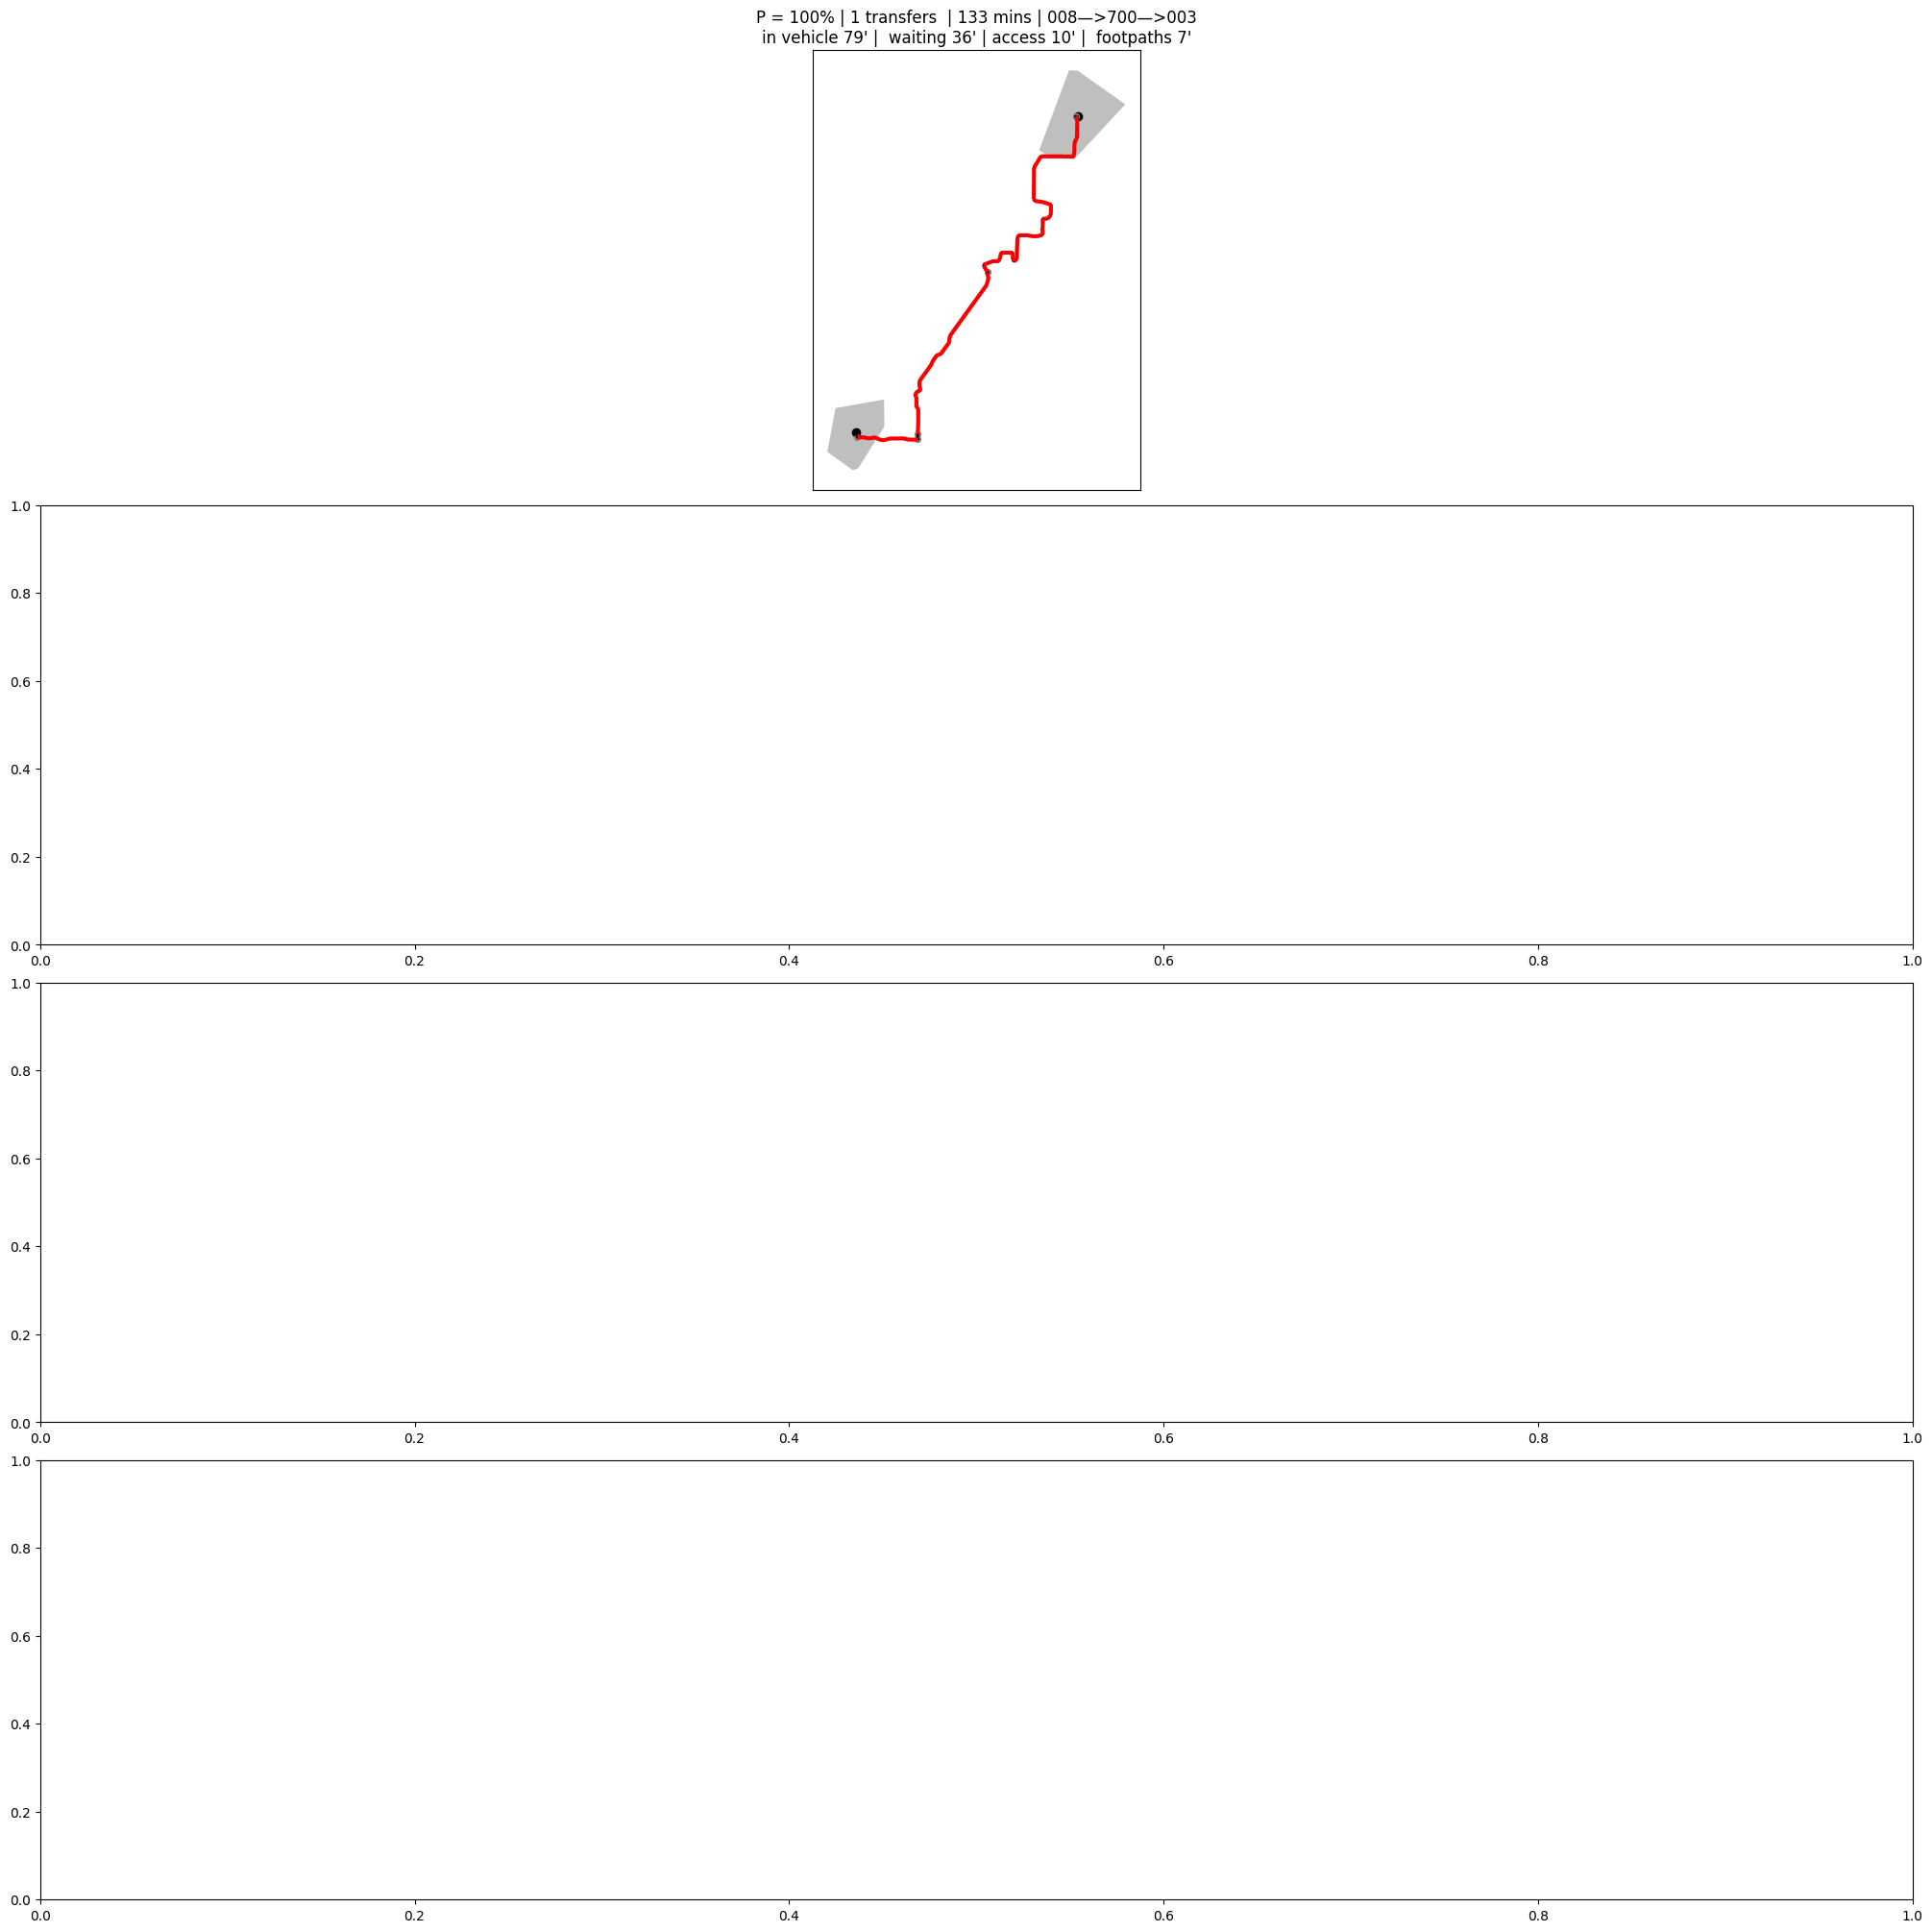

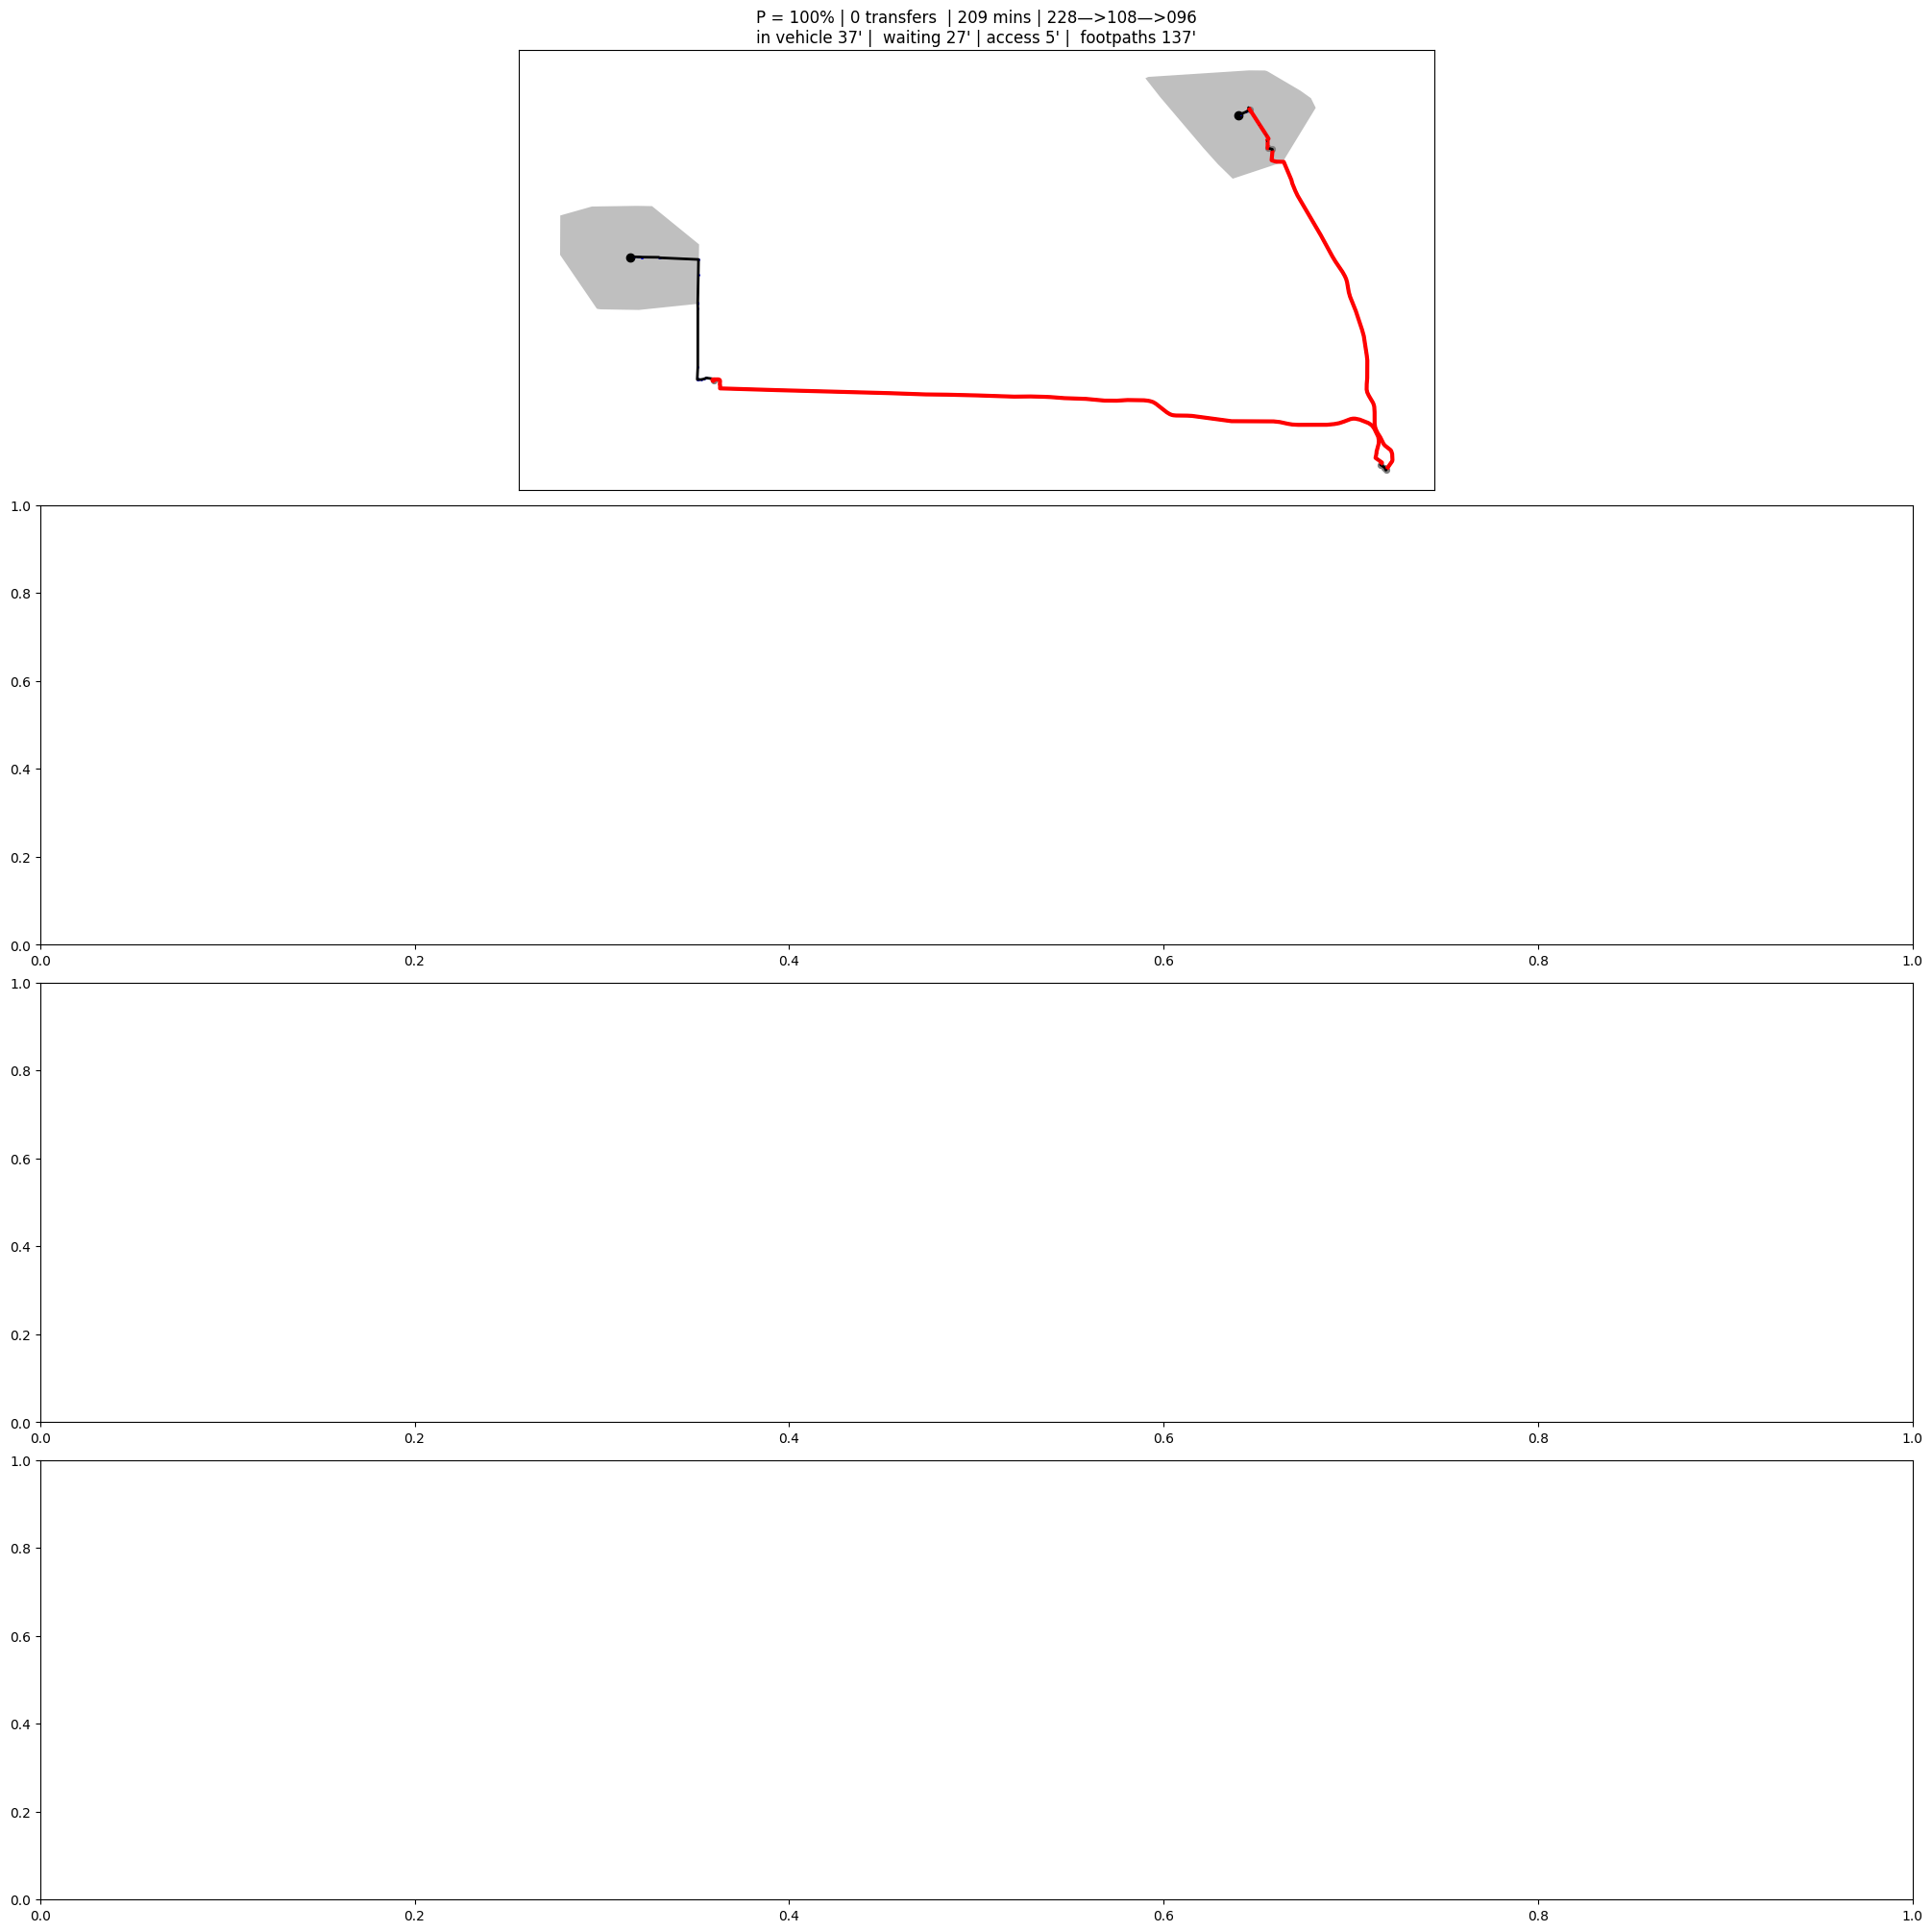

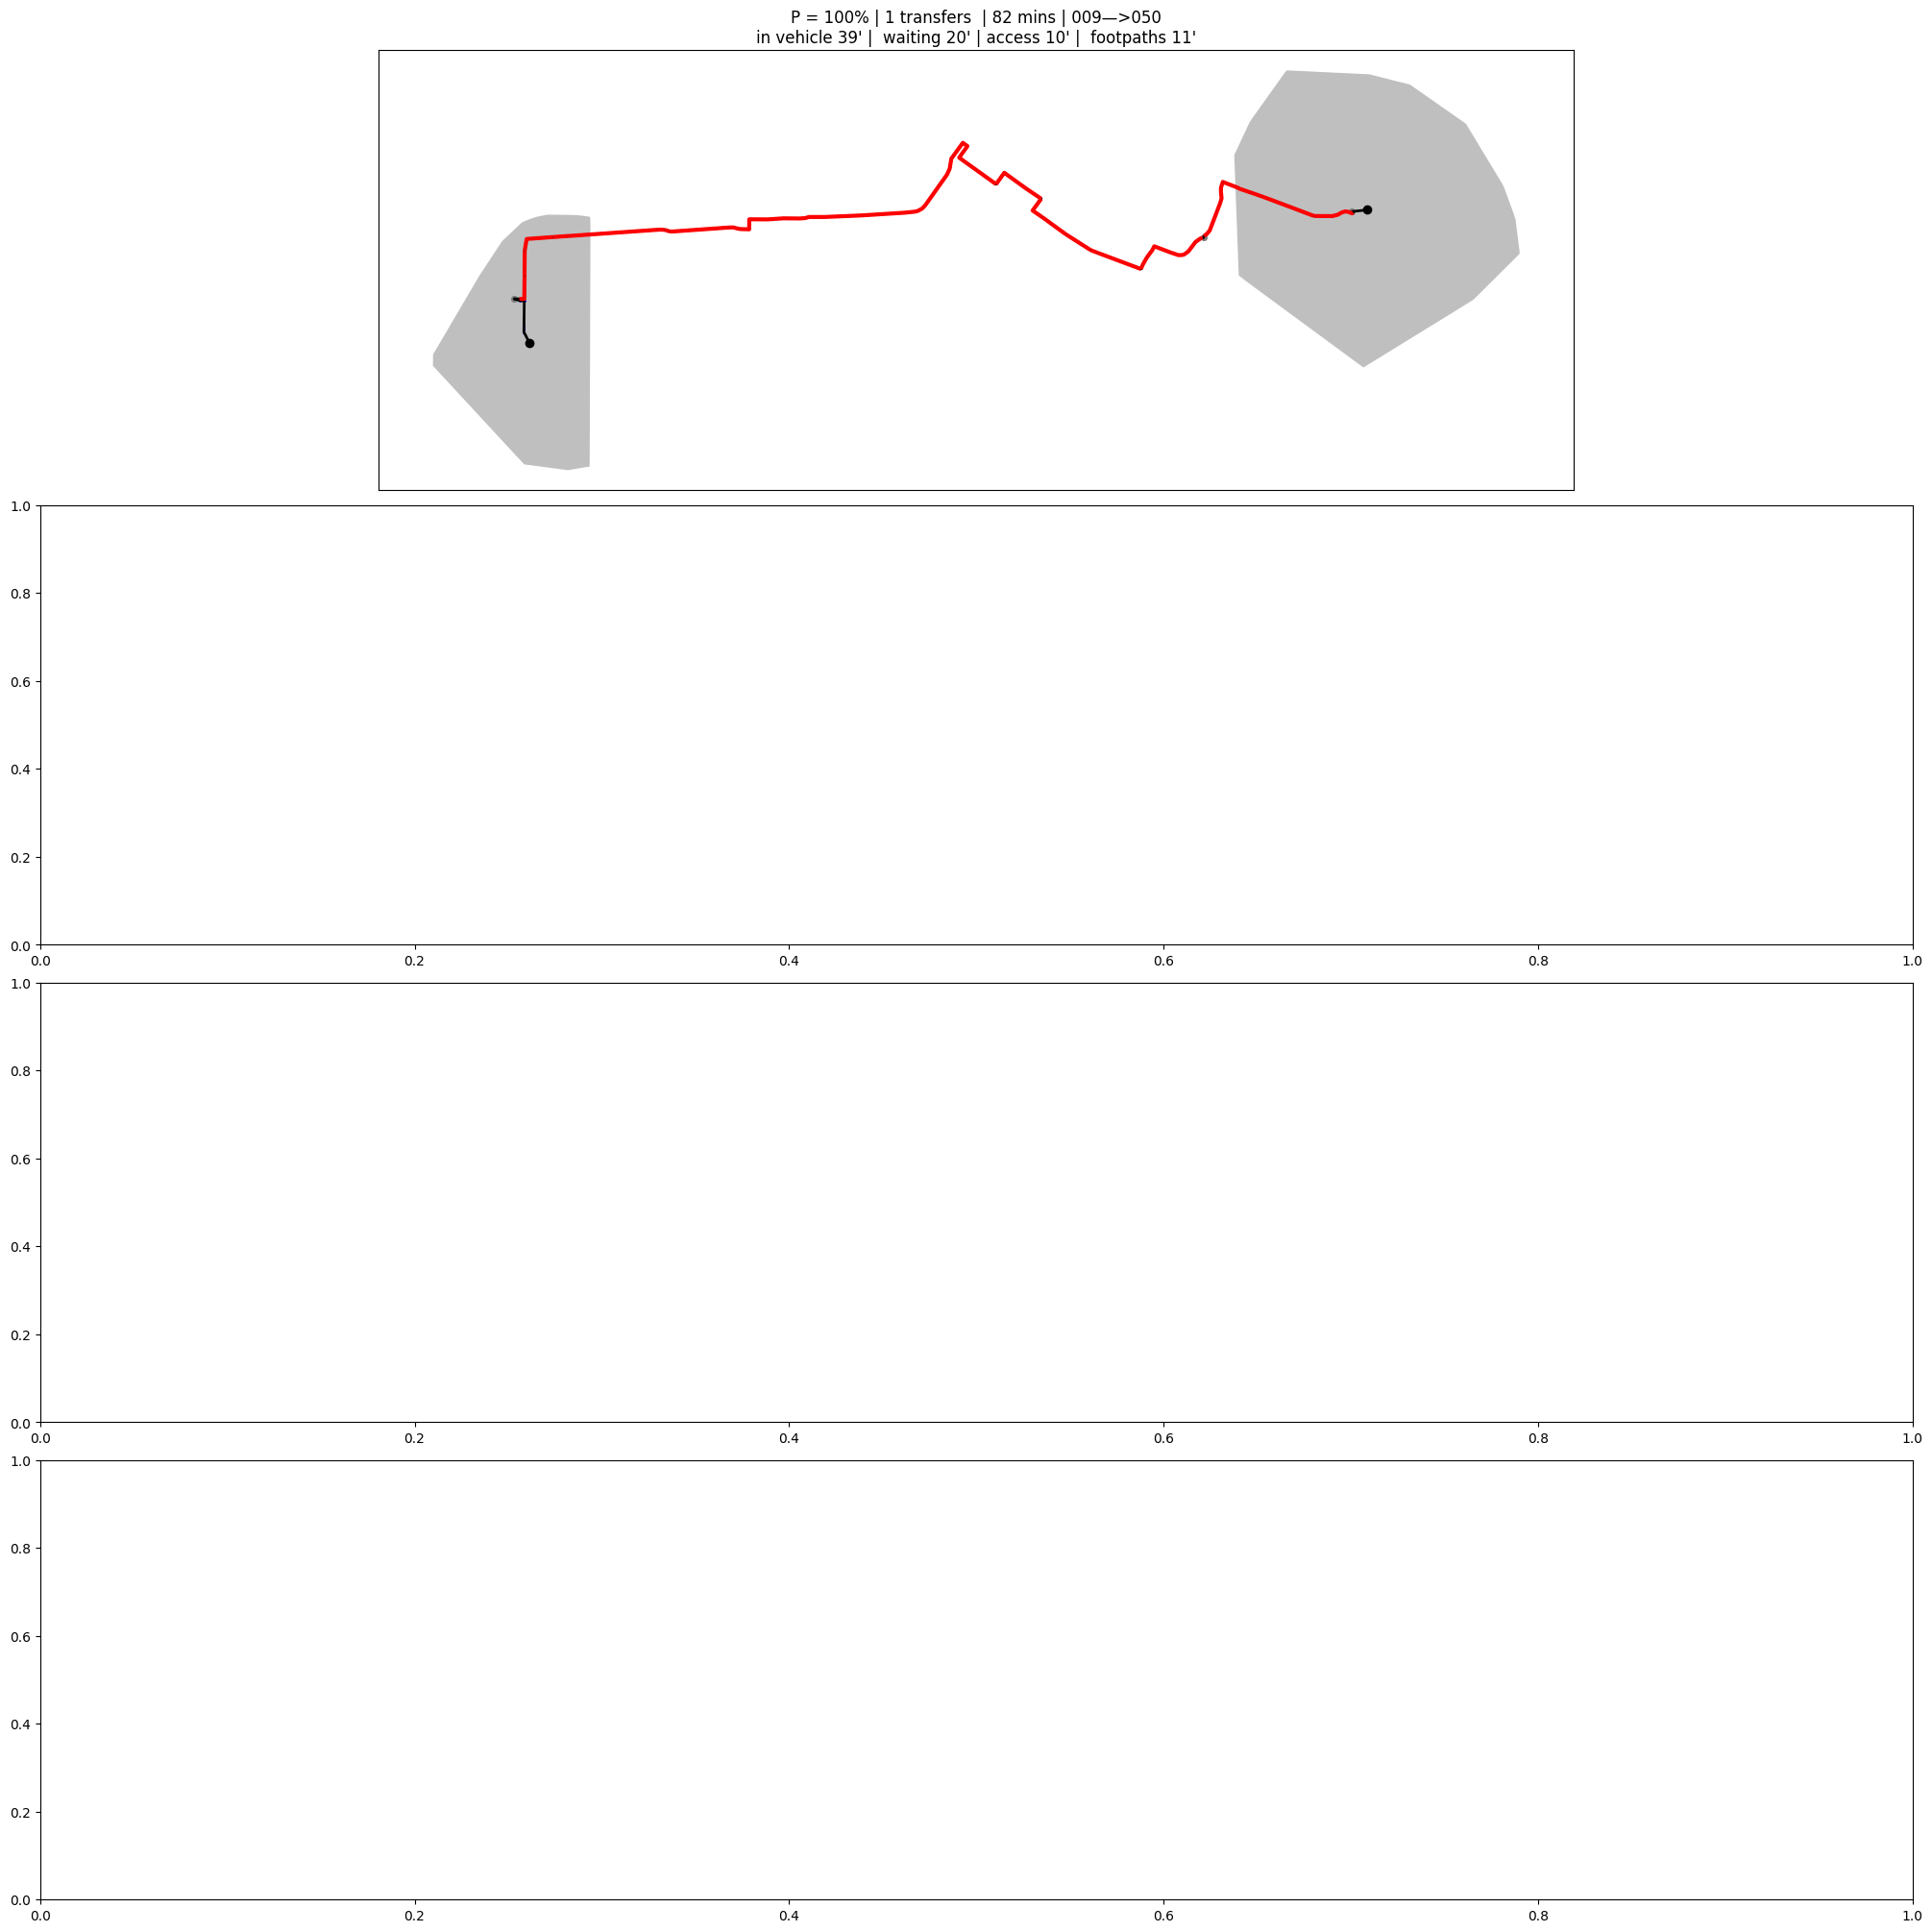

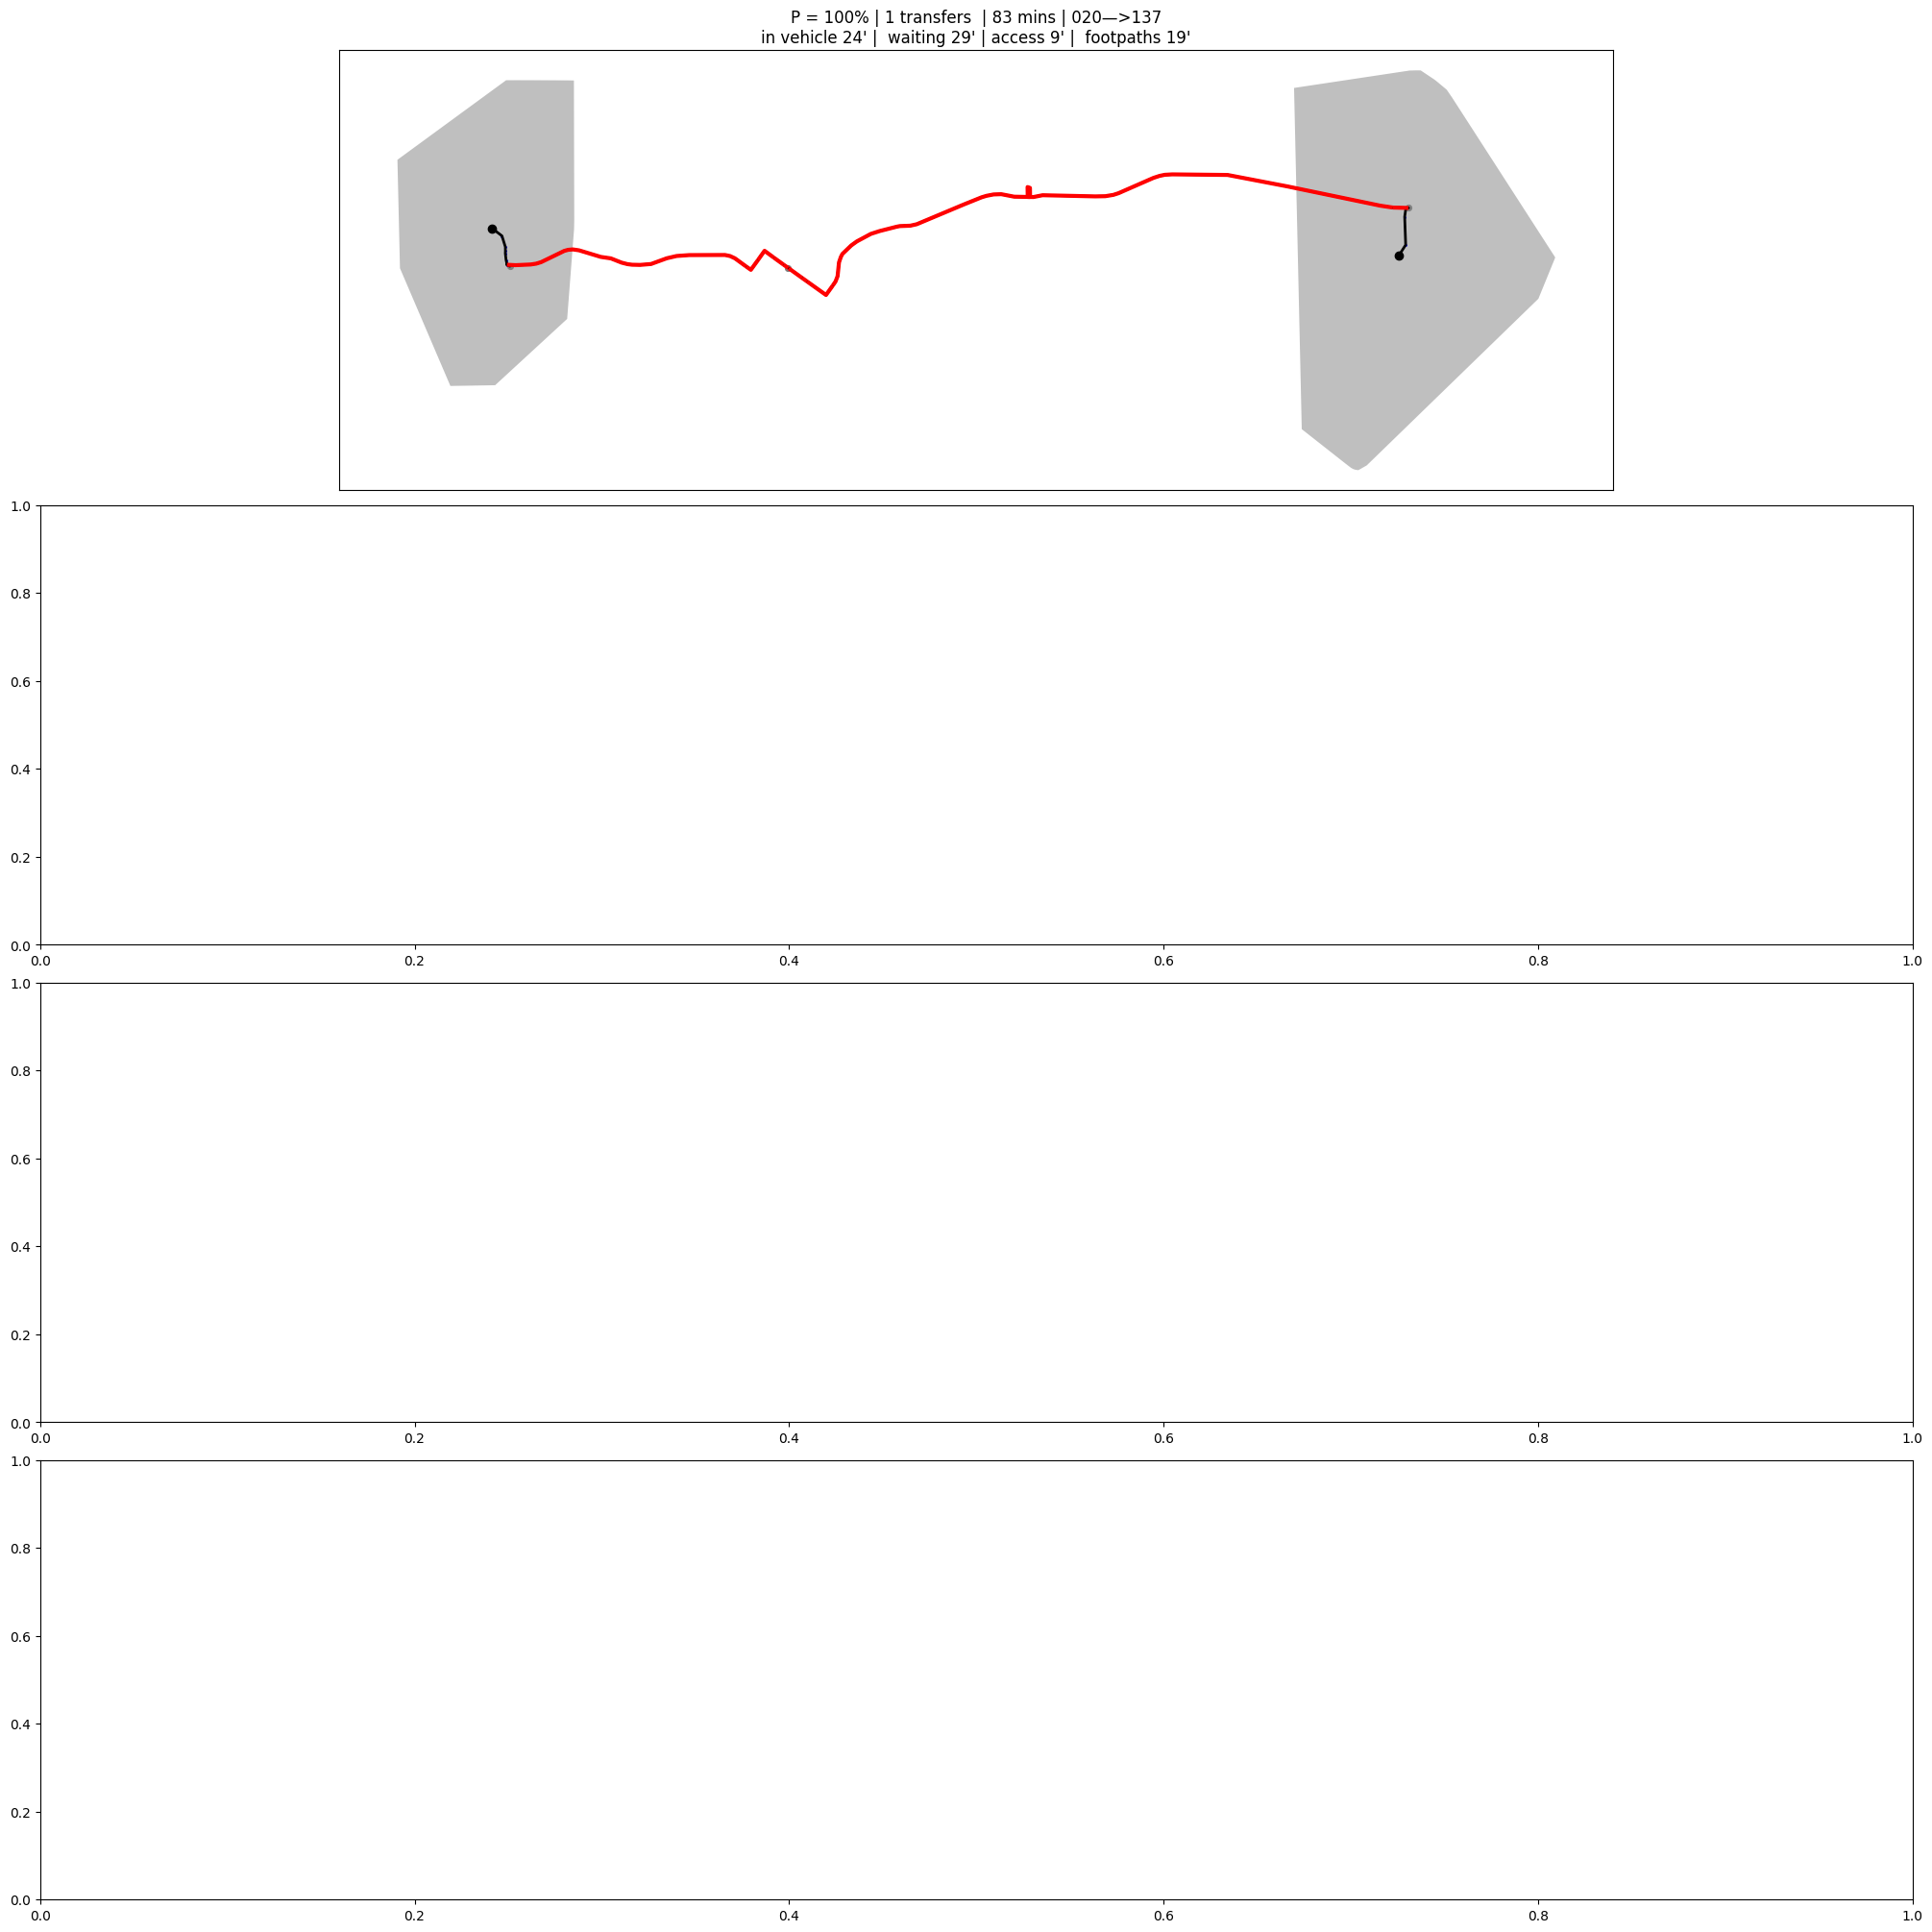

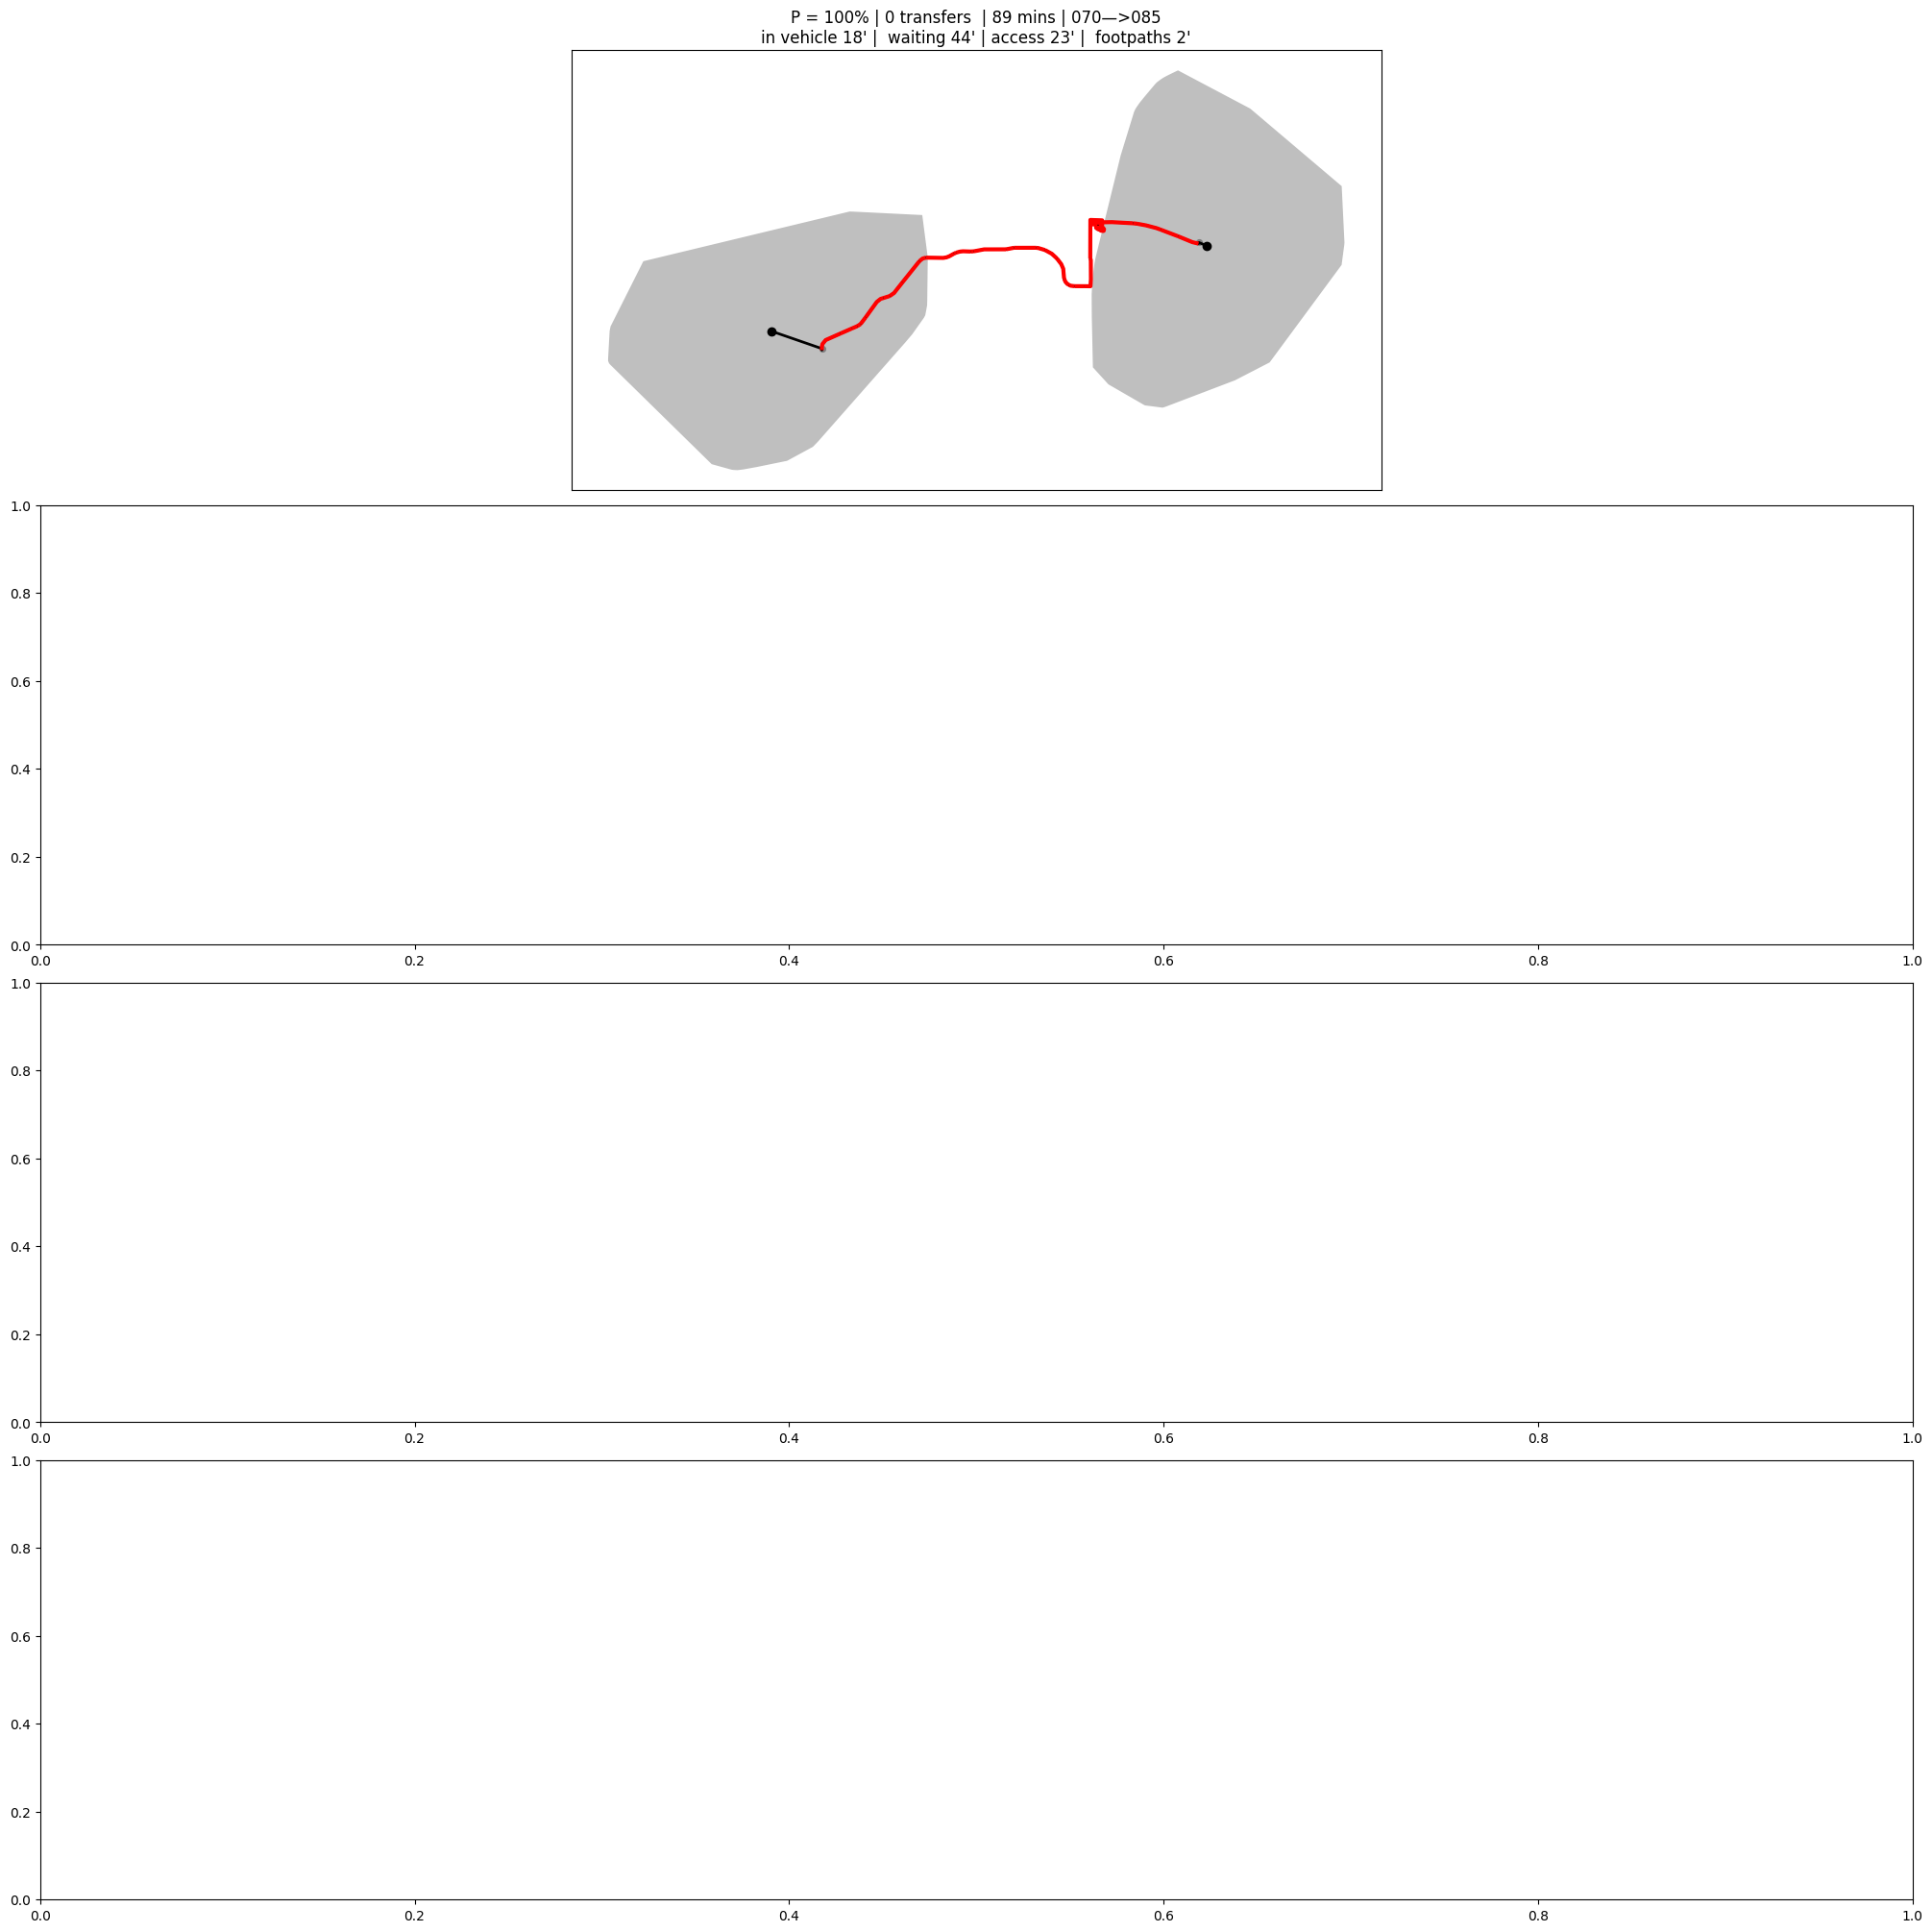

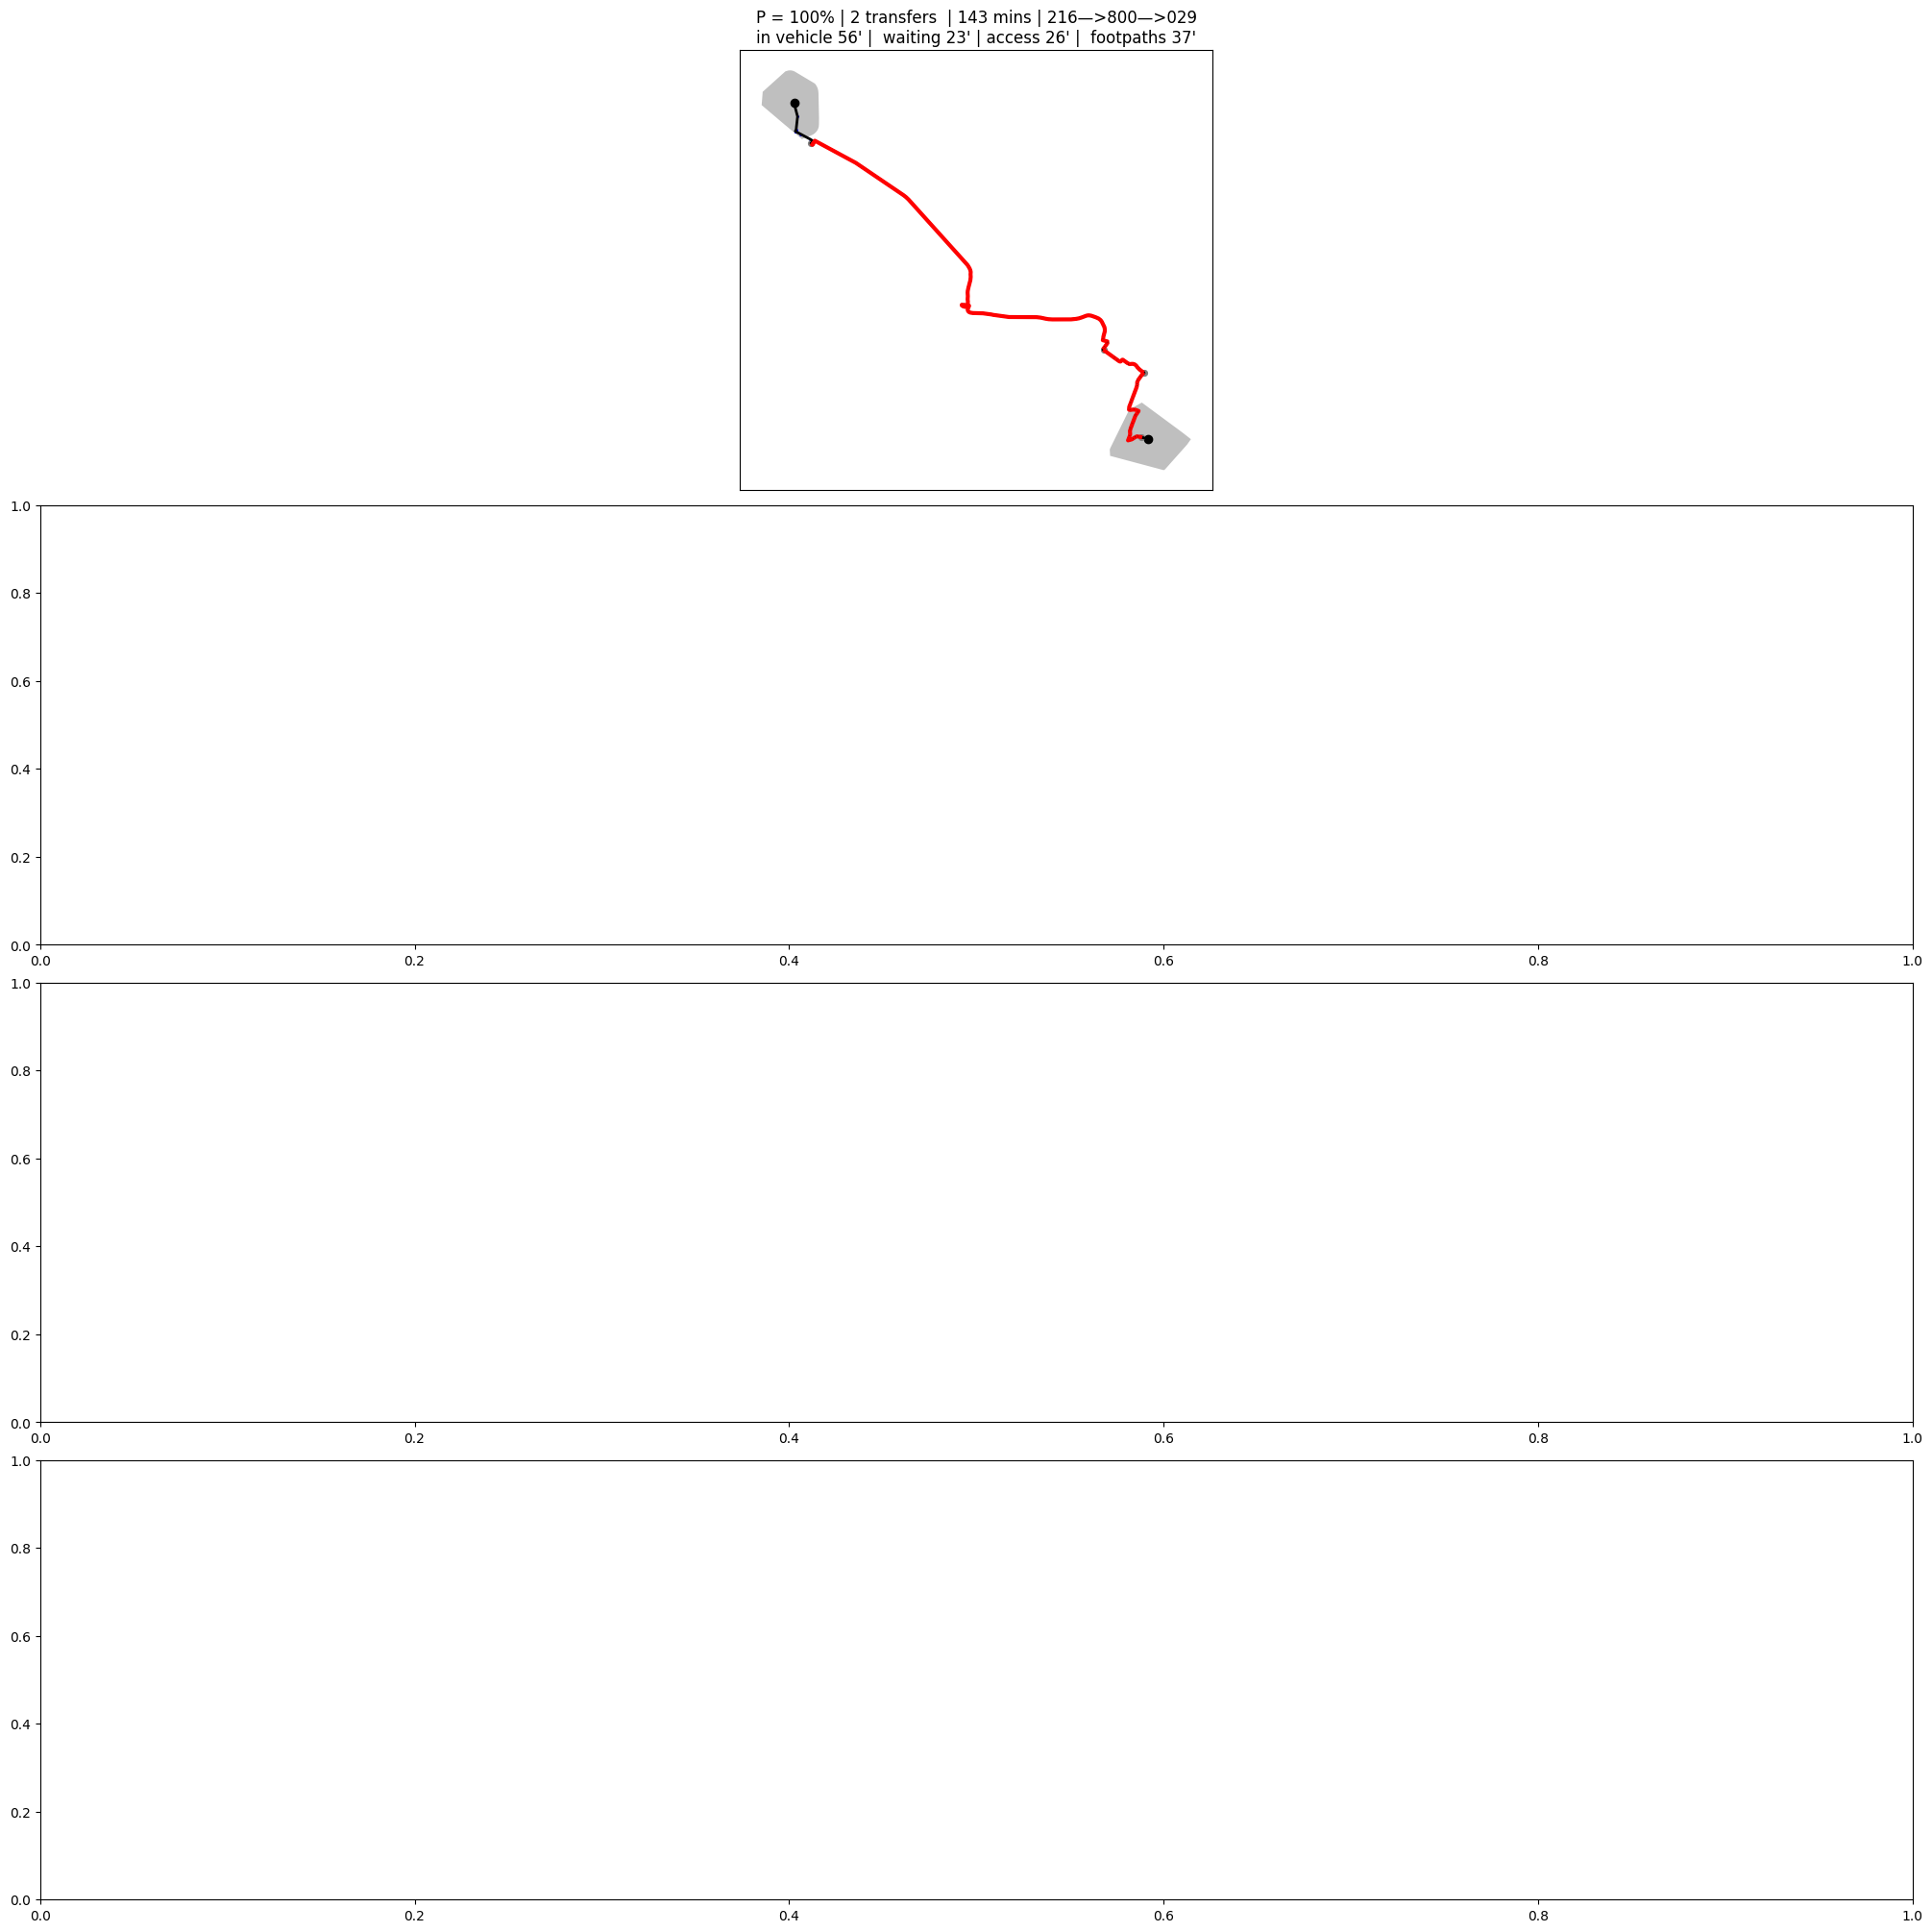

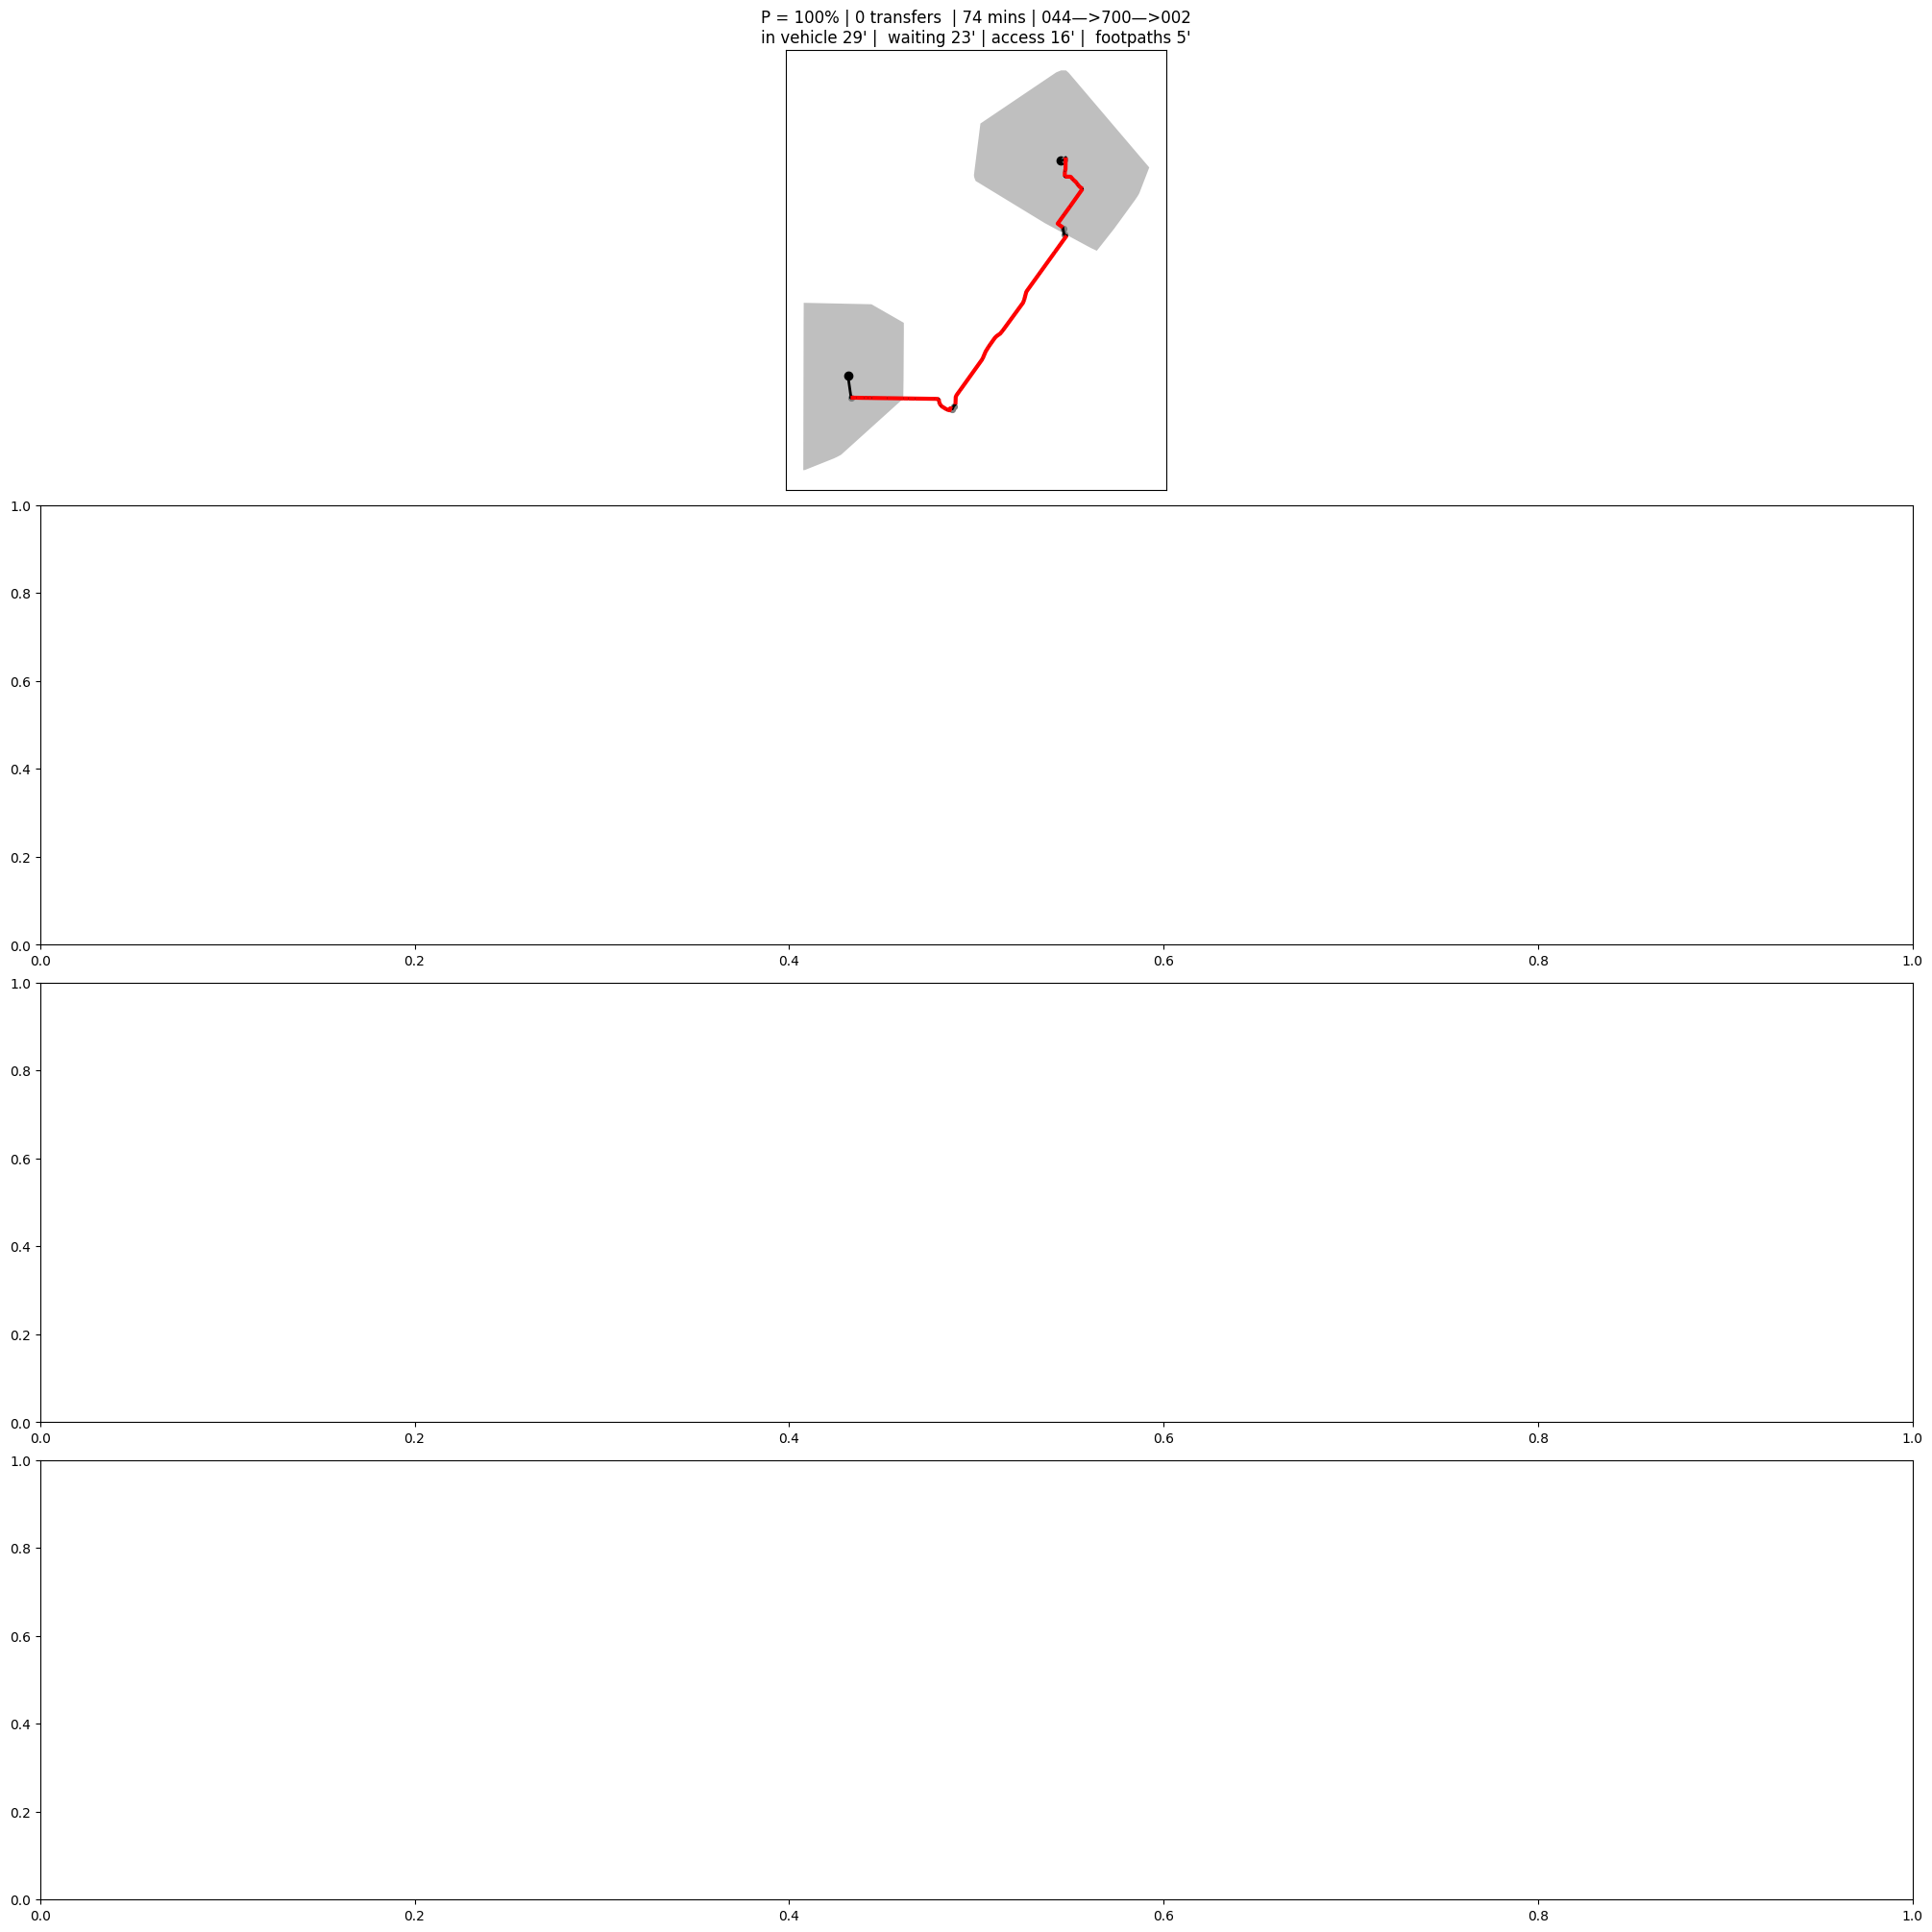

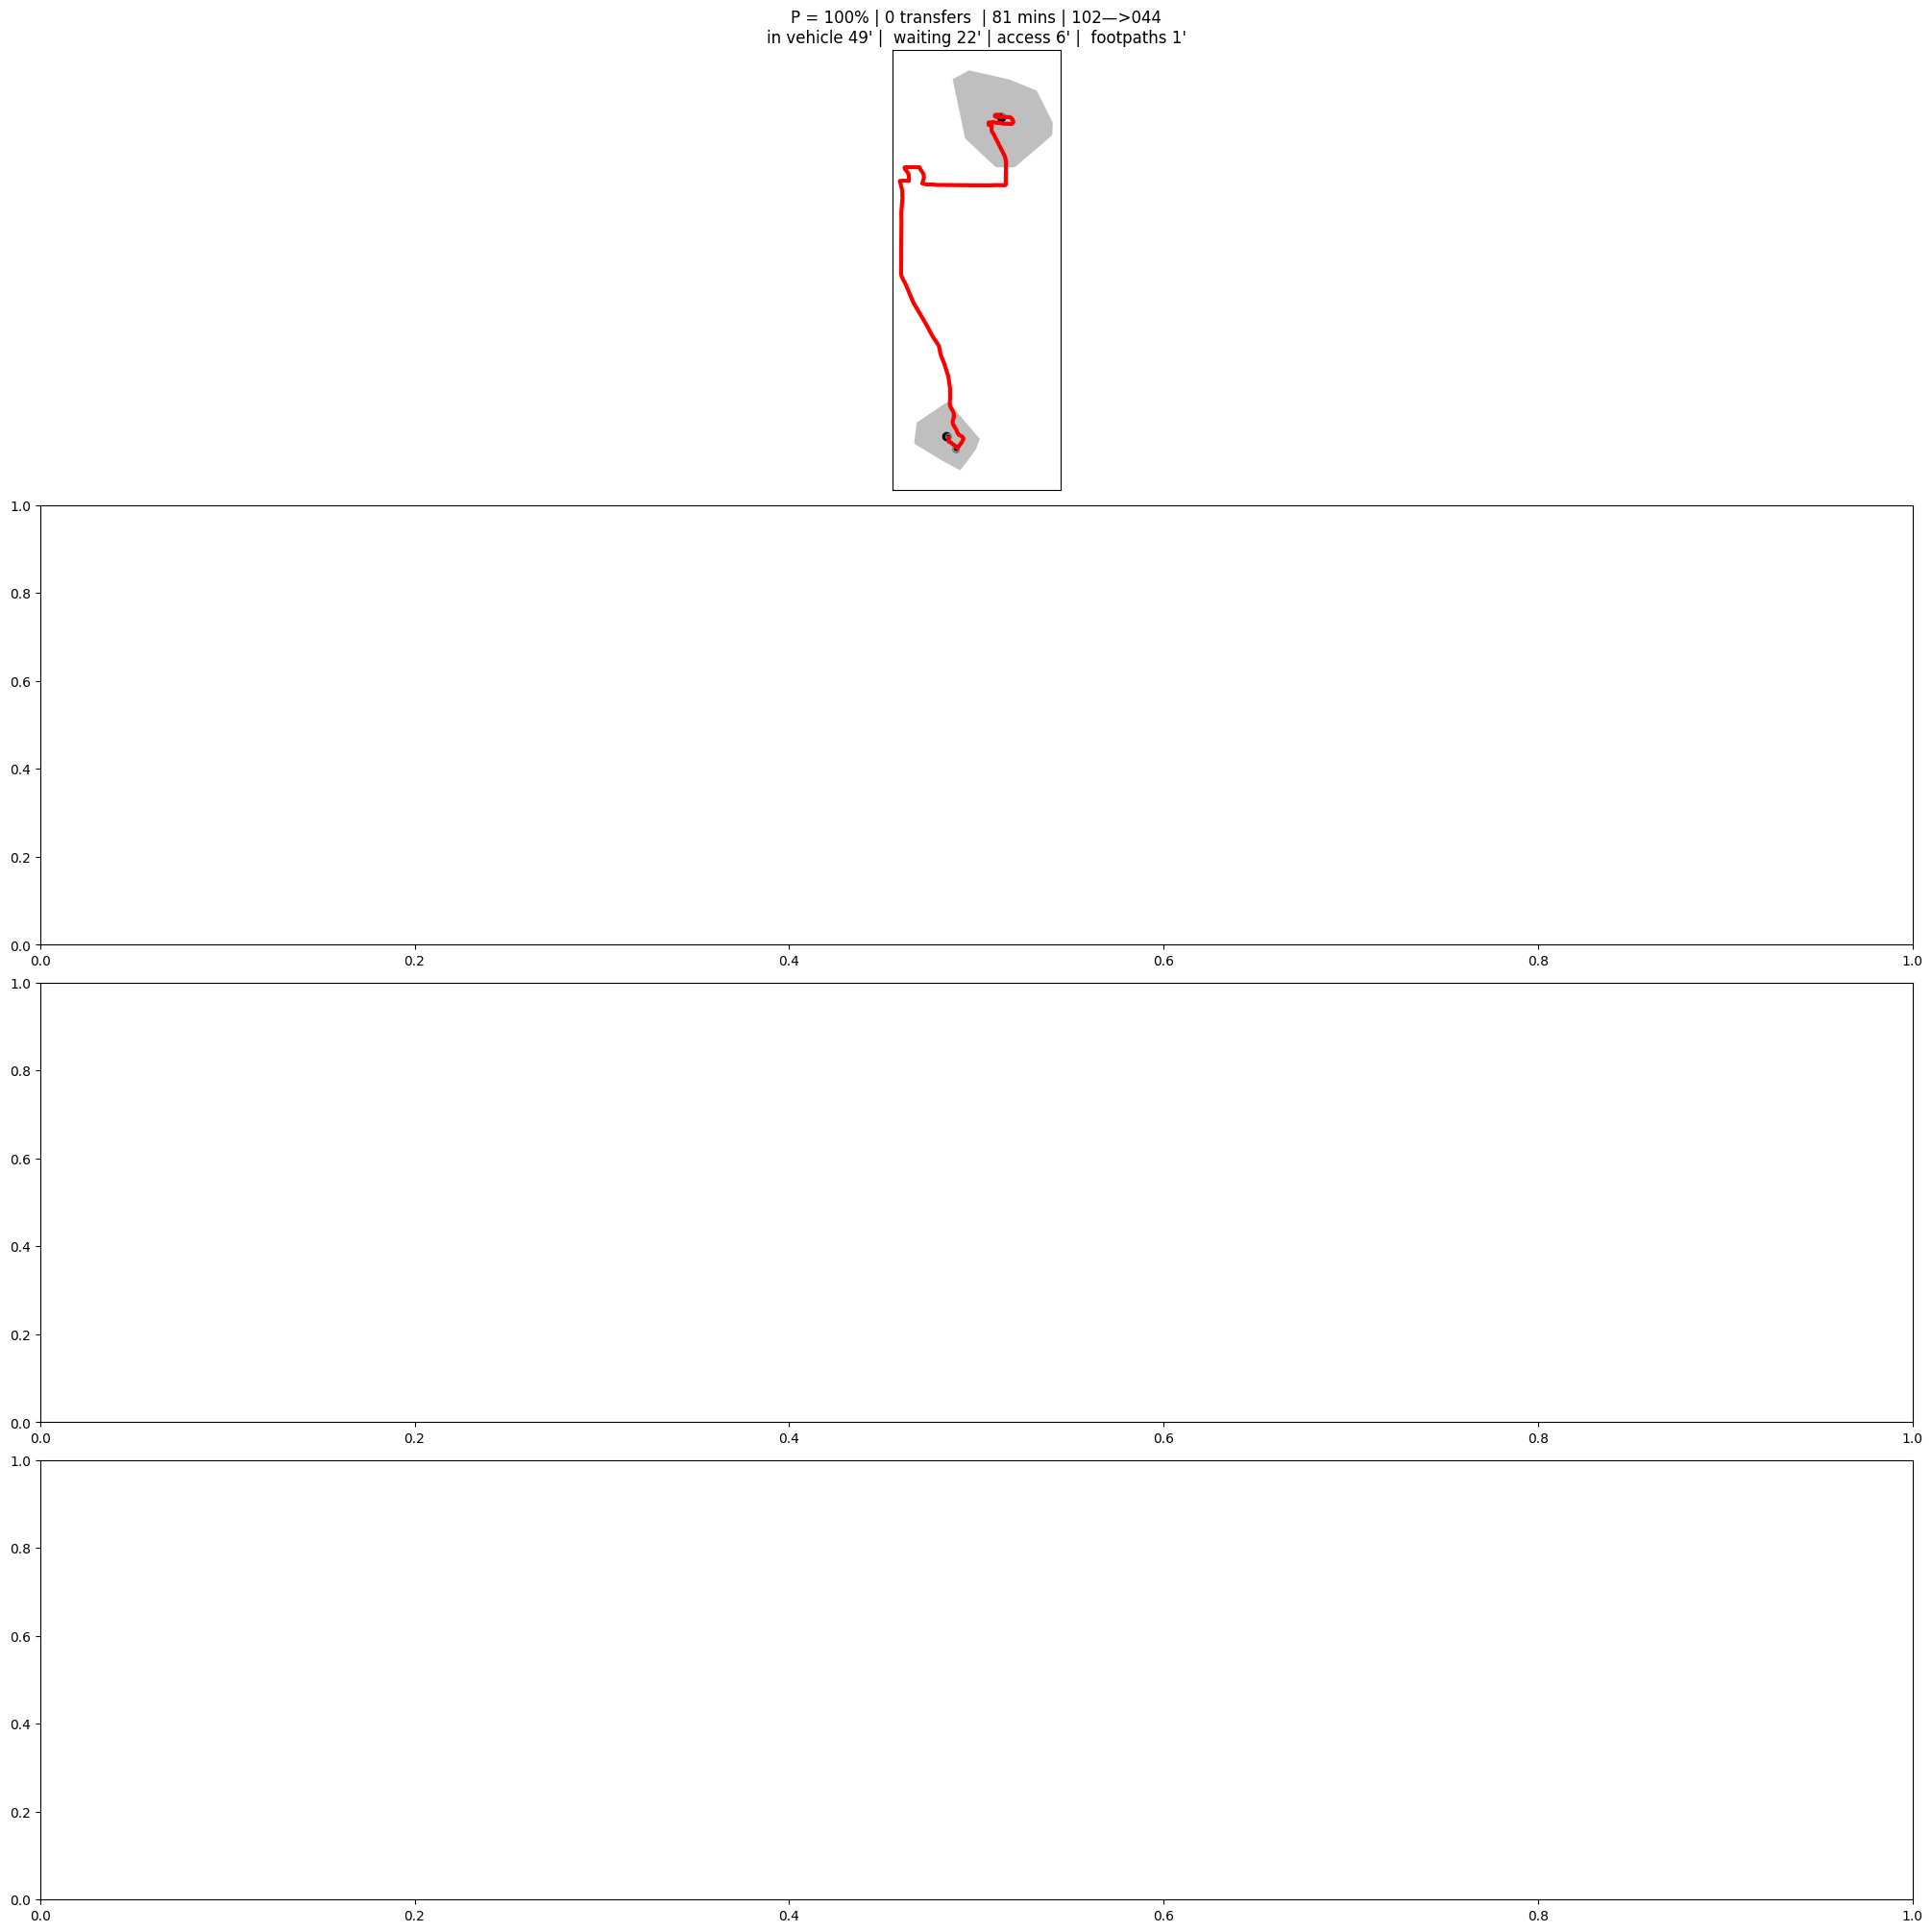

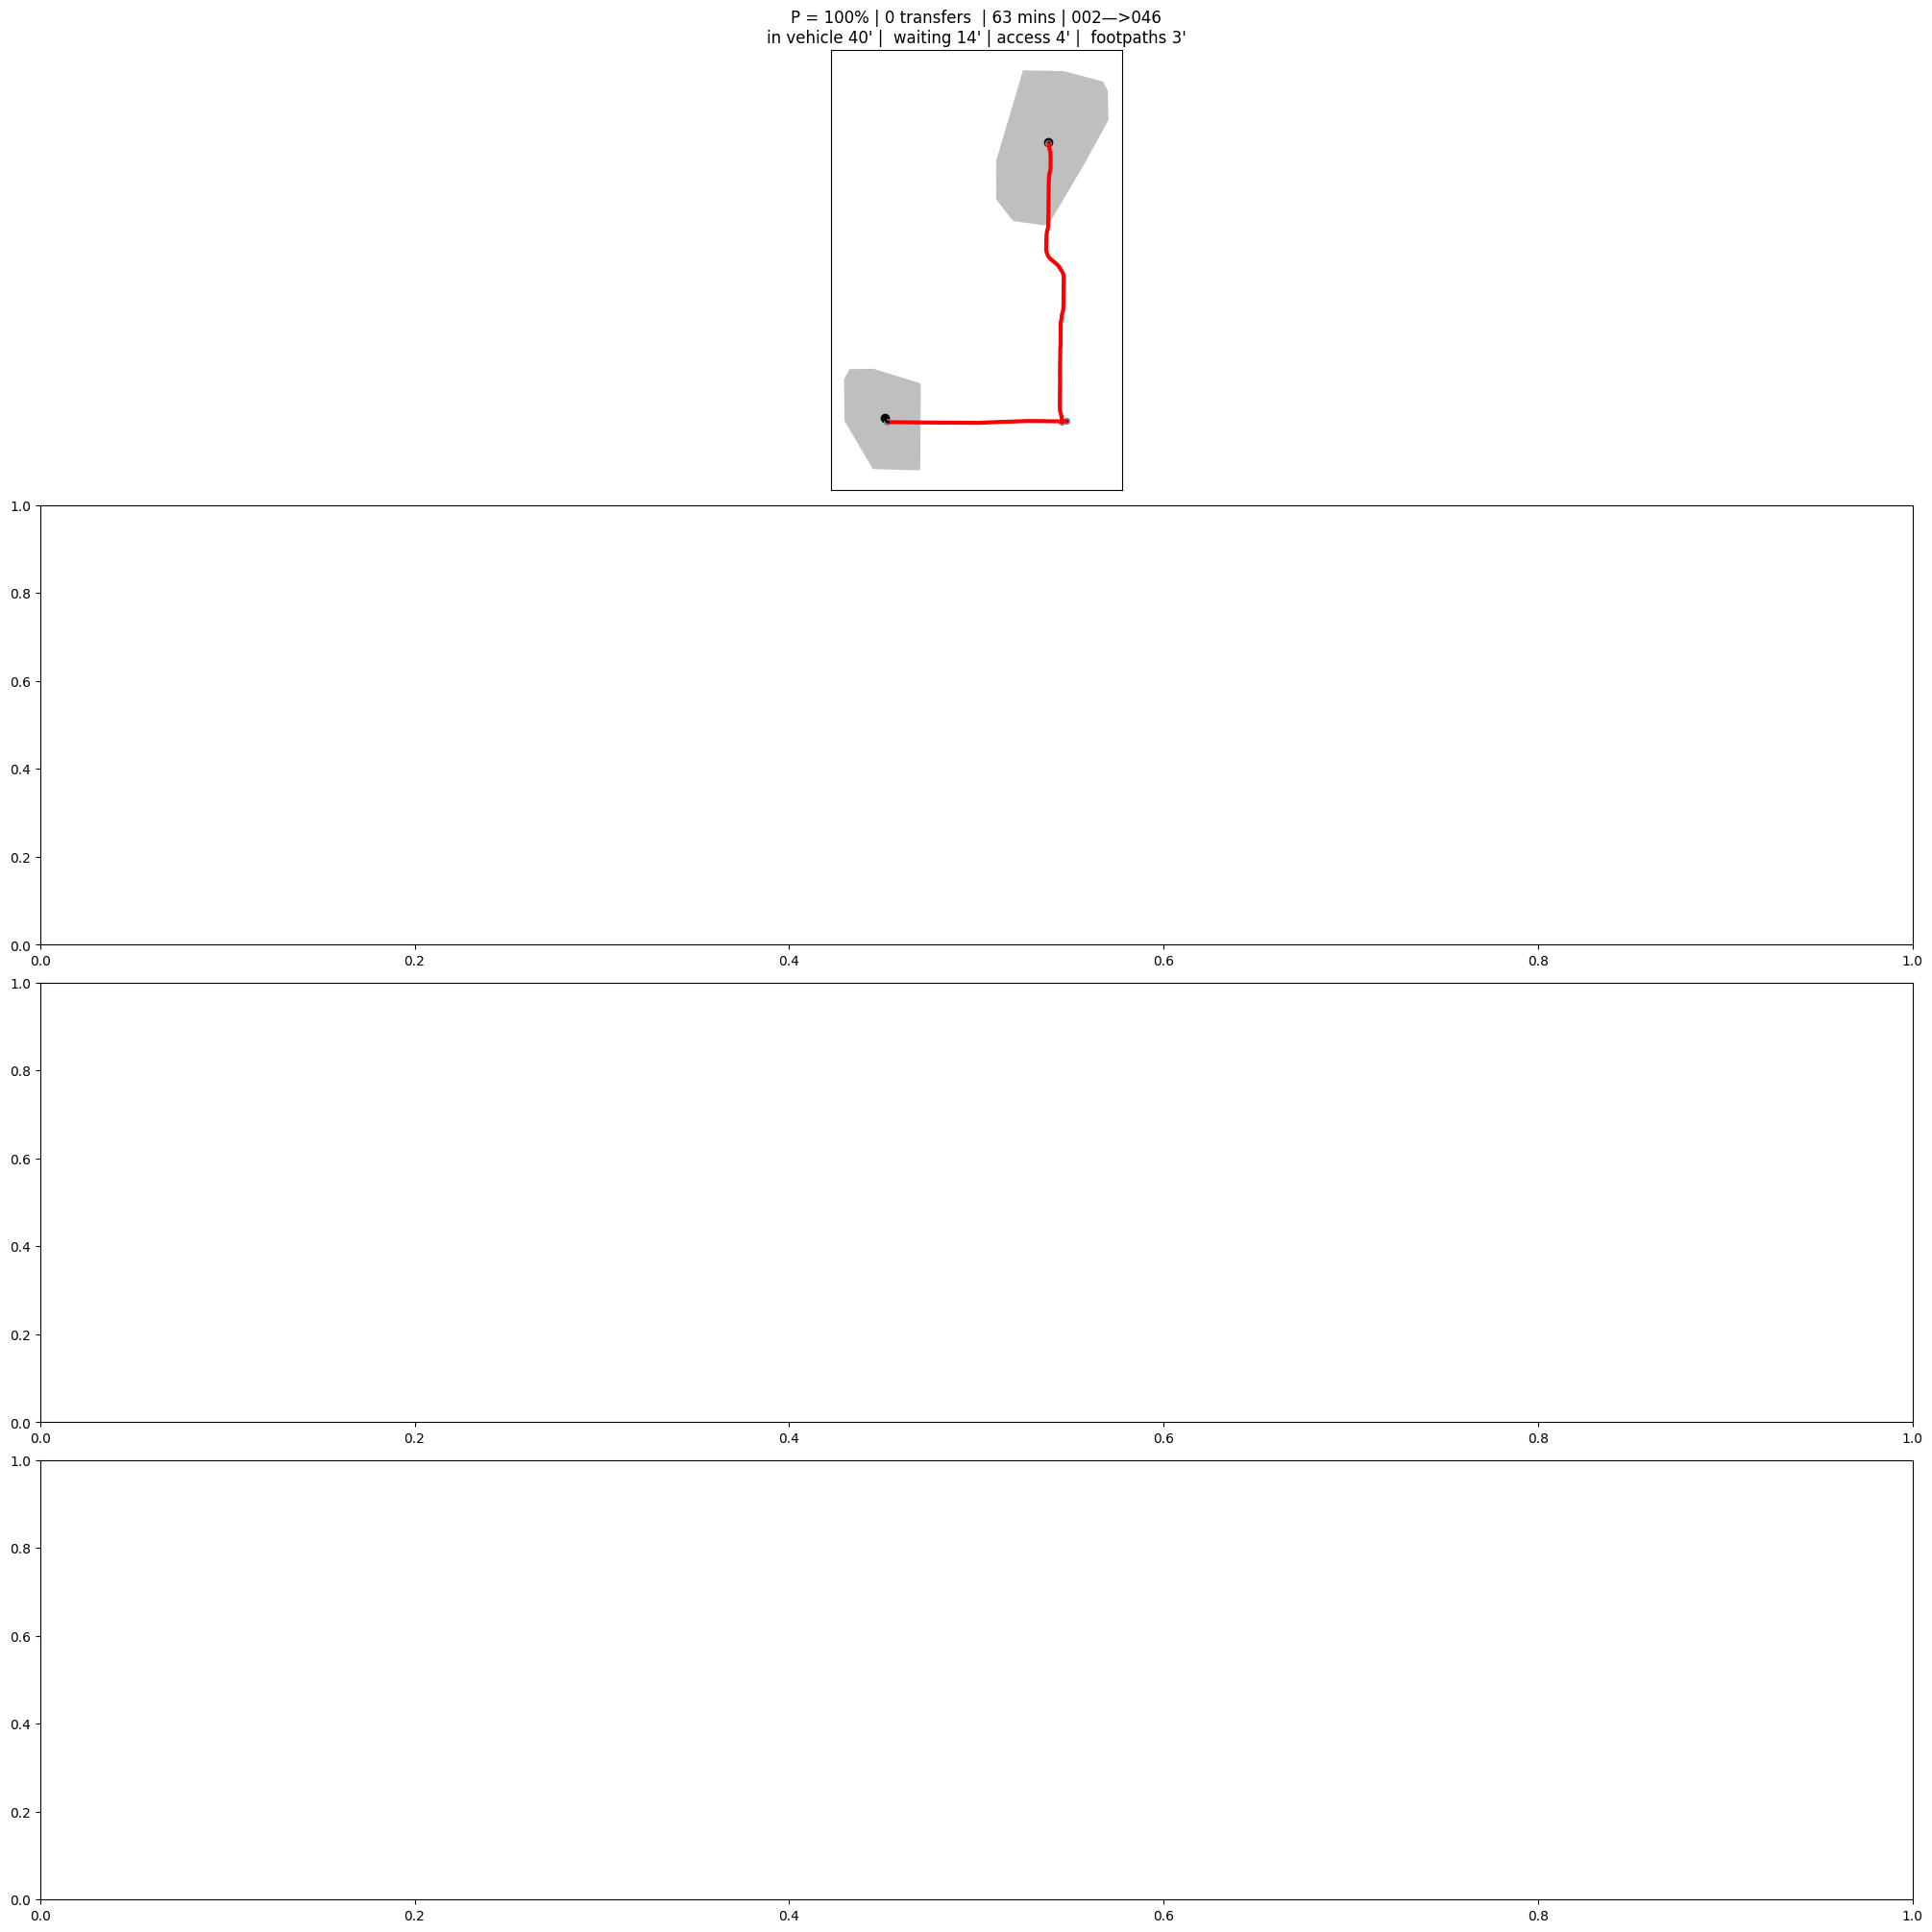

In [86]:

sm.pt_los = sm.pt_los.sort_values(('pt_captive', 'probability'), ascending=False)
if manual:

    for o,d in od_list:
        origin, destination= o, d
        n =  len(sm.pt_los.set_index(['origin', 'destination']).loc[(origin, destination)])

        rows = 1

        if n > 6:
            rows = 3
        if n > 12:
            rows = 4

        columns = n // rows + bool(n%rows)


        #url = 'http://a.basemaps.cartocdn.com/light_nolabels/tileZ/tileX/tileY.png'
        fig, axes = sm.plot_separated_paths(
            origin, destination, rows=rows, figsize=[20, 20],
            title='title', constrained_layout=True, zoom=13
        )
        '''
        ax = fig.get_axes()[0]
        bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        fig.set_size_inches(bbox.width*columns, rows*(bbox.height))
        fig.constrained_layout = True
        '''
#fig.savefig(plot_path + 'logit.png', bbox_inches='tight')

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


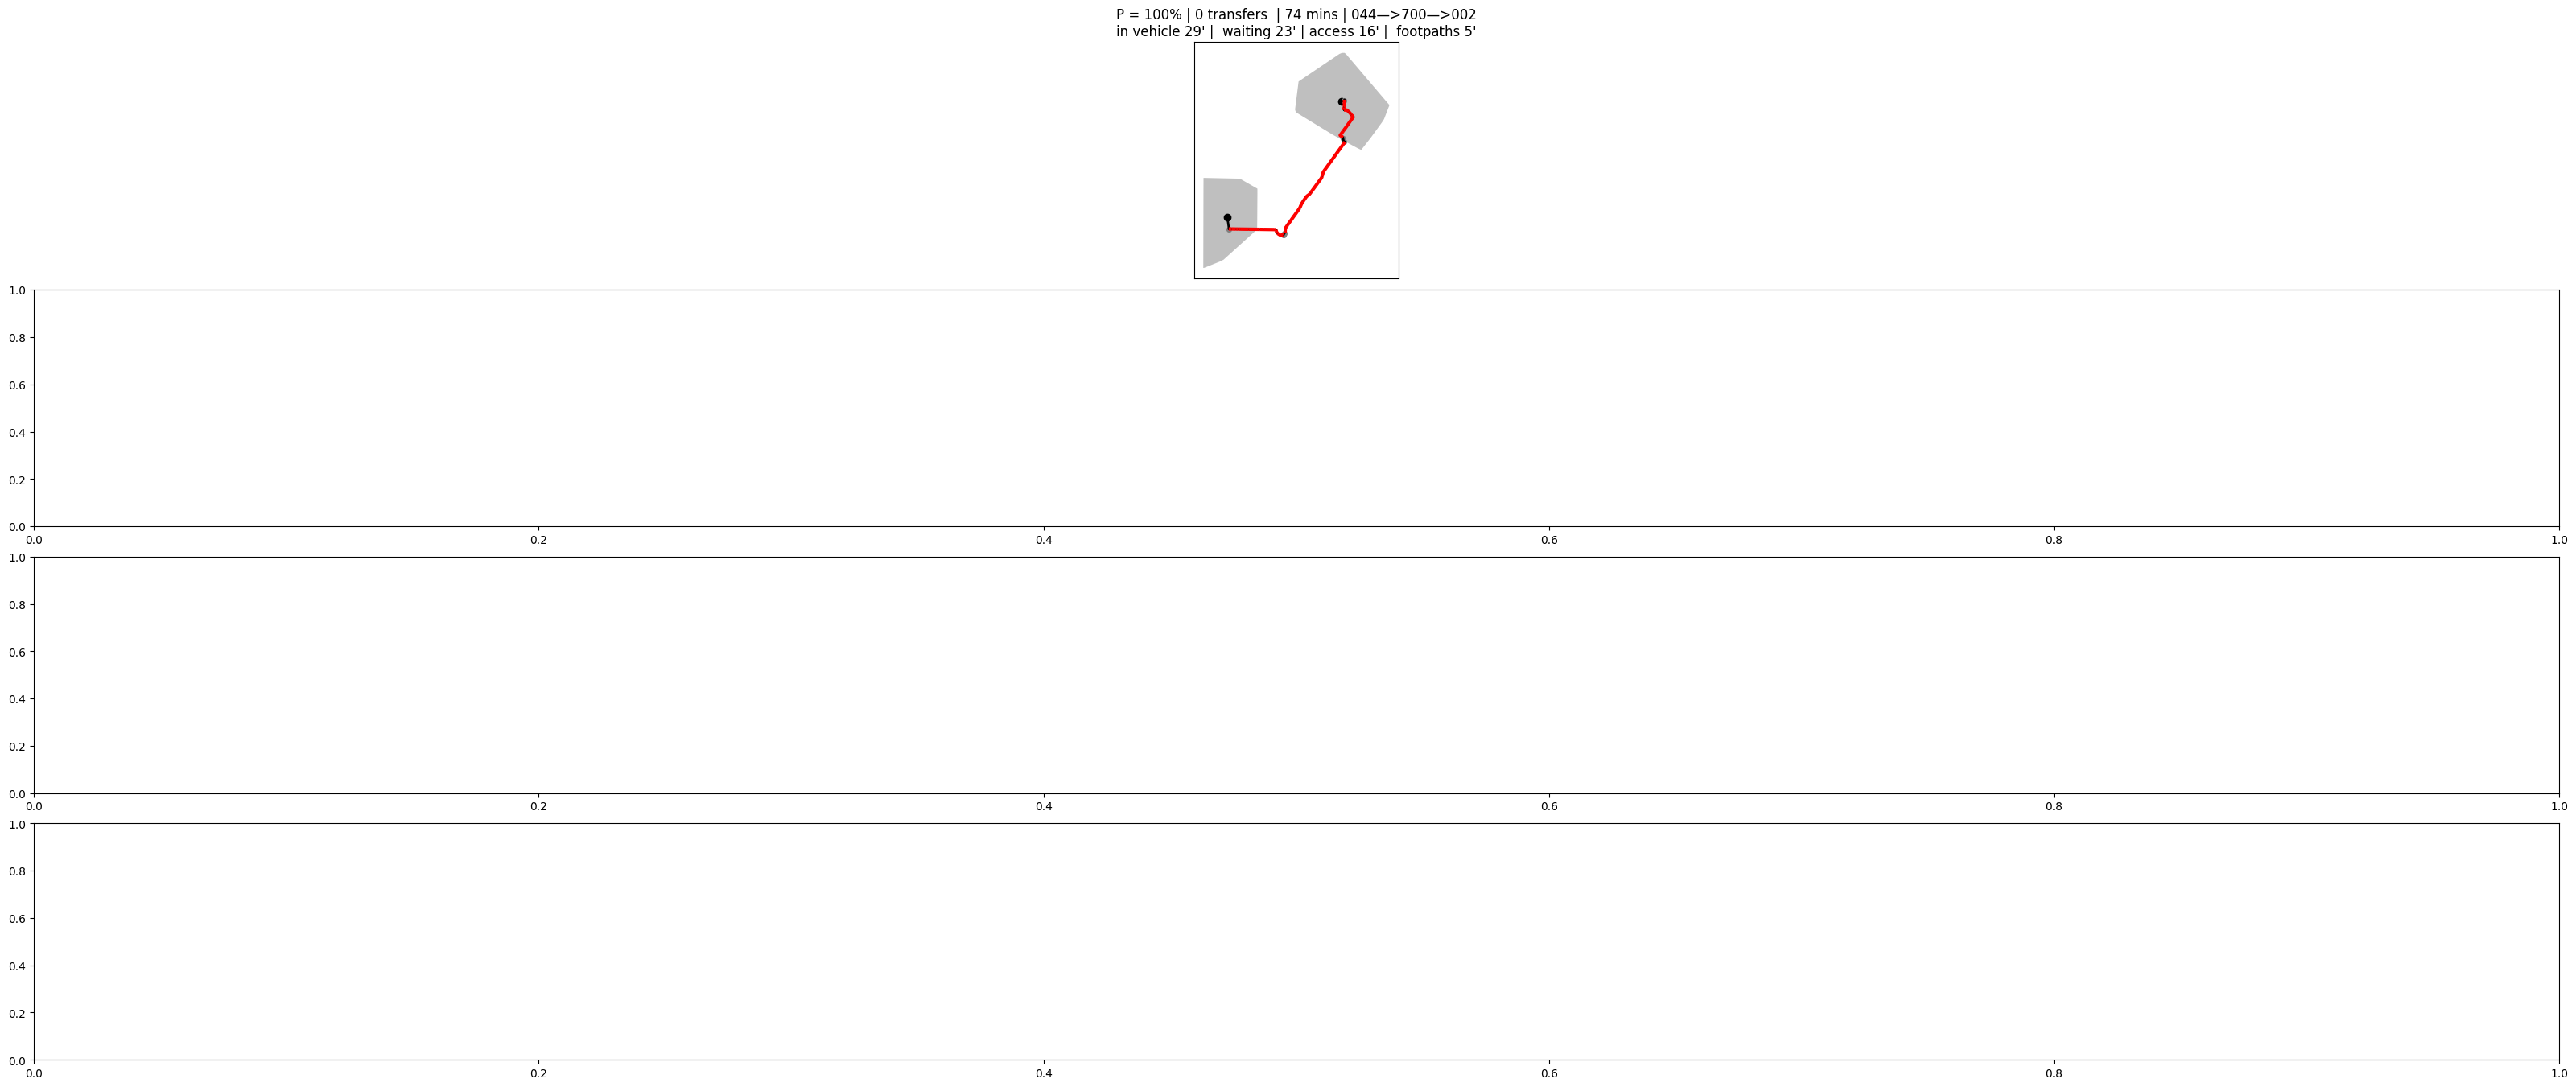

In [46]:
los = plot_sm.pt_los.copy()
los= los.loc[los[('pt_captive', 'probability')] > 0.15]
plot_sm.pt_los = los.sort_values(('pt_captive', 'probability'), ascending=False)
sm.pt_los = sm.pt_los.sort_values(('pt_captive', 'probability'), ascending=False)
if manual:
    origin, destination='zone_488', 'zone_4'
    n =  len(sm.pt_los.set_index(['origin', 'destination']).loc[(origin, destination)])

    rows = 2
    if n > 6:
        rows = 3
    if n > 12:
        rows = 4

    columns = n // rows + bool(n%rows)


    
    fig, axes = plot_sm.plot_separated_paths(
        origin, destination, rows=rows, figsize=[15, 15],
        title='title', constrained_layout=True,
        zoom=13
    )
    ax = fig.get_axes()[0]
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.set_size_inches(bbox.width*columns, rows*(bbox.height))
    fig.constrained_layout = True

100%|██████████| 1/1 [00:01<00:00,  1.97s/it]


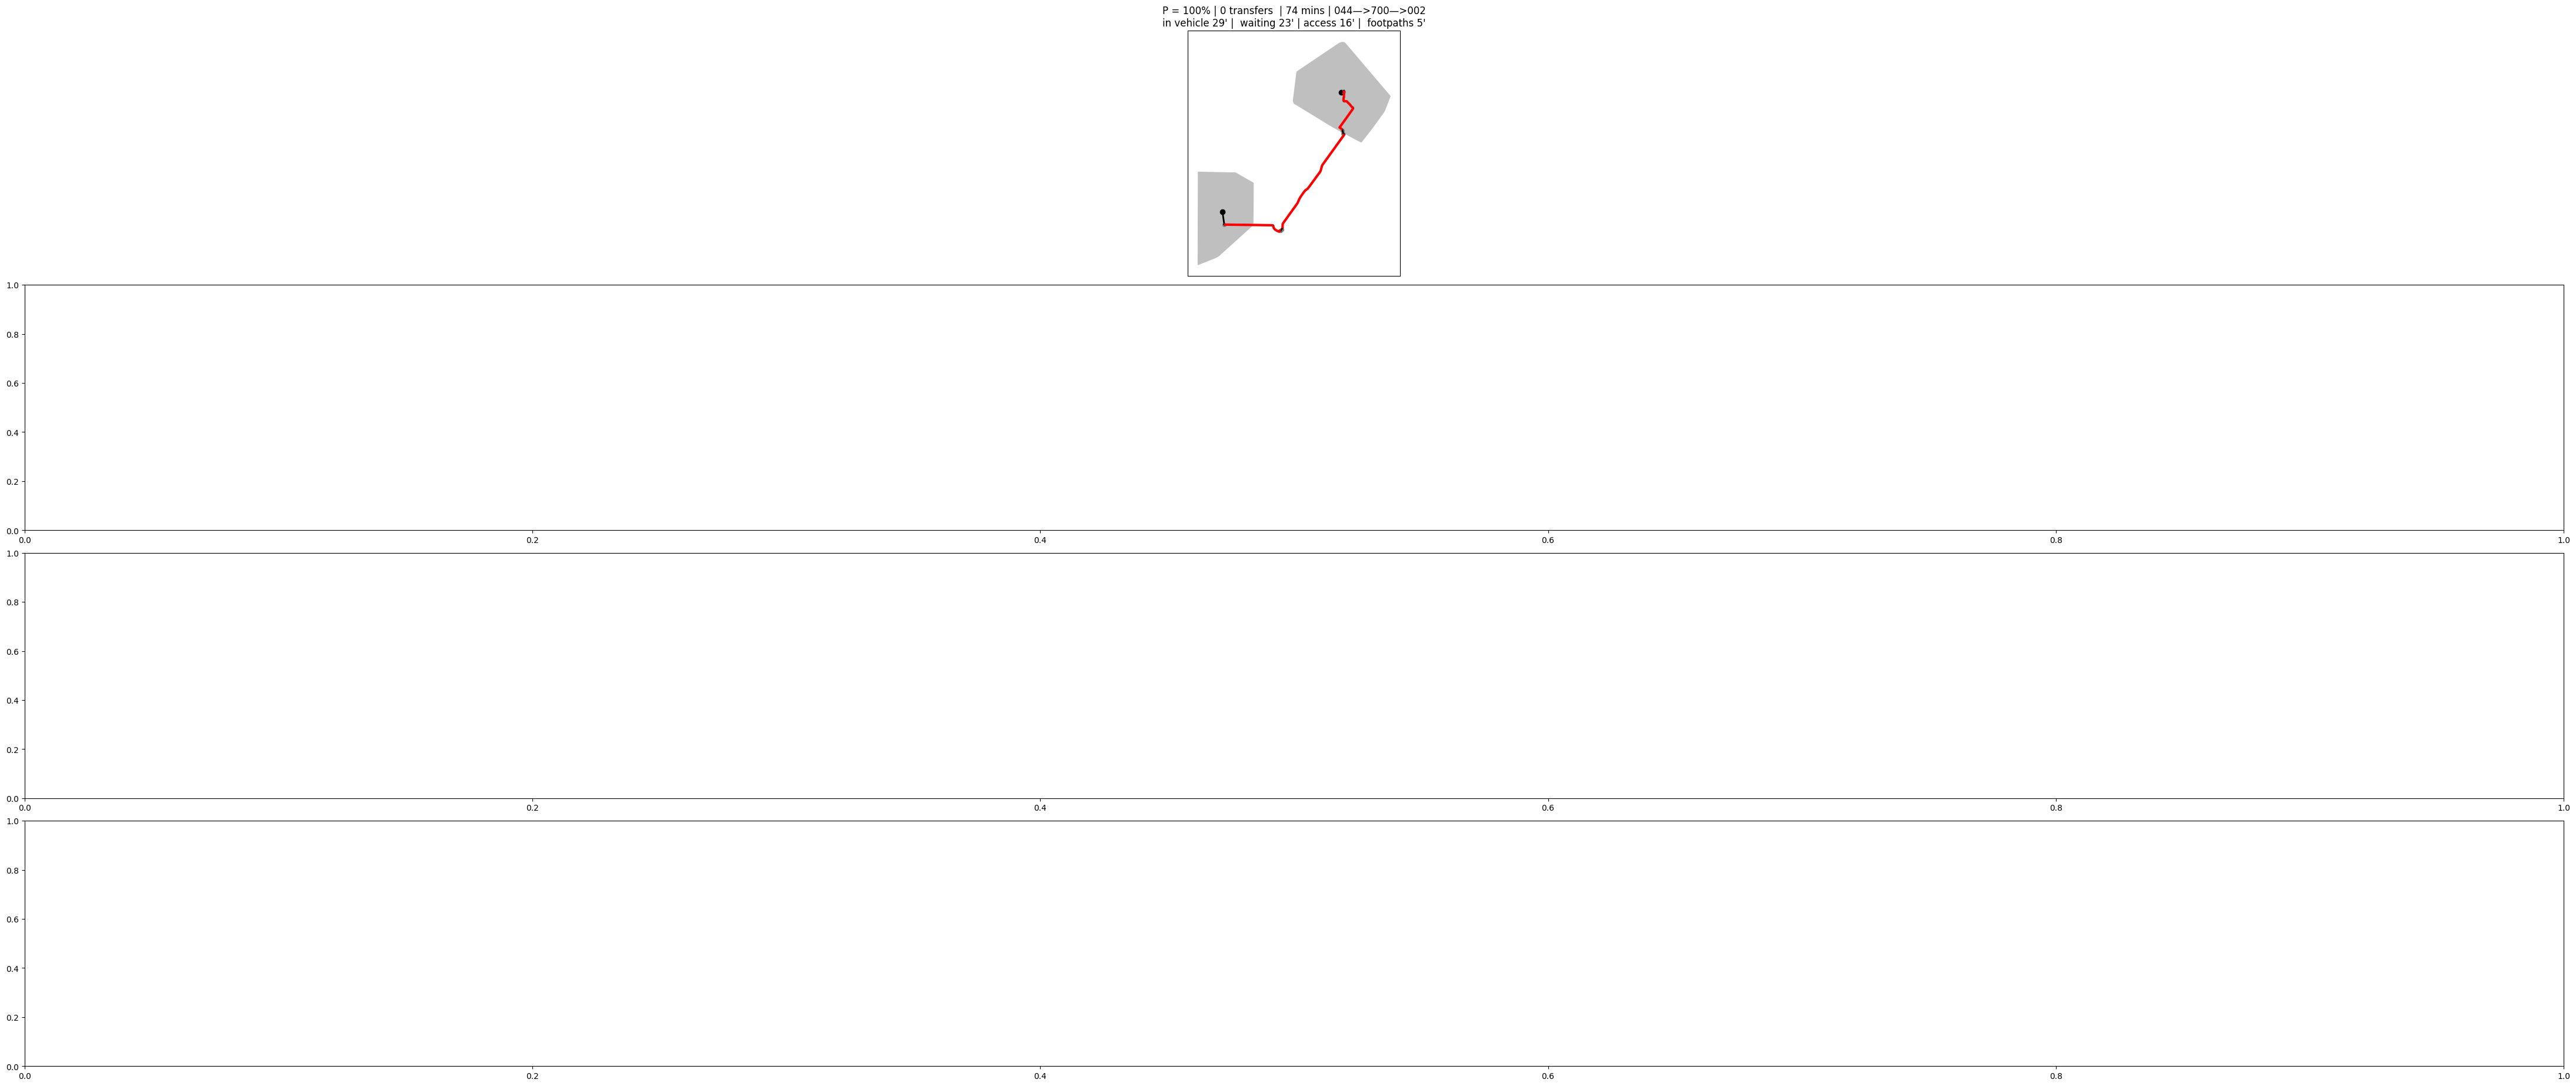

In [102]:
if manual:
    origin, destination='zone_488', 'zone_4'
    n =  len(sm.pt_los.set_index(['origin', 'destination']).loc[(origin, destination)])

    rows = 2
    if n > 6:
        rows = 3
    if n > 12:
        rows = 4

    columns = n // rows + bool(n%rows)


    
    fig, axes = plot_sm.plot_separated_paths(
        origin, destination, rows=rows, figsize=[20, 20],
        title='title', constrained_layout=True,
        zoom=13
    )
    ax = fig.get_axes()[0]
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.set_size_inches(bbox.width*columns, rows*(bbox.height))
    fig.constrained_layout = True